# Final Project - Click-Through Rate Prediction
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Fall 2018`__
__`Authors: Kevin Gifford, Matthew Prout, Ben Thompson, Daniel Van Lunen`__

In this final project, we explore a set of Criteo advertising data to perform Click-Through Rate (CTR) prediction using distributed logistic regression. This notebook is organized around the following sections:
* Introduction and Problem Statement
* Algorithm Selection and Description
* Exploratory Analysis of the Dataset
* Algorithm Implementation
* Course Context and Conclusions


## Notebook Set-Up
This section contains set up code, including necessary libraries, dependencies, and initialization of the distributed computing environment.

In [2]:
import time
import numpy as np
from pyspark.sql.types import StructType, StructField, LongType, FloatType
import pyspark.sql
import re
import ast
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML 
%matplotlib inline

# Set number of partitions for parallelization. This assumes processing on an 8-node cluster of 4 cores each.
# Update this constant to match your setup.
numParts = 32

## Create Spark Session

In [3]:
# start Spark Session
from pyspark.sql import SparkSession
app_name = "w261_final"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .getOrCreate()
sc = spark.sparkContext

## Read in Data, Convert hex to int

In [4]:
# read in the data - adjust file paths if necessary. Txt files are publicly accessible on the 
# project's Google Cloud Storage bucket.

# sample RDD for EDA - random sample of 1% of data
sampleRDD = sc.textFile('gs://gptv01/data/261final/train1percentsample.txt')
# Toy file for algorithm illustration 0.1% of data
toyRDD = sc.textFile('gs://gptv01/data/261final/trainpt1percentsample.txt')

In [5]:
# Functions to parse the data
def ConvertNumber(idx, num):
    """ 
    Parses fields and takes categorical field hashes
    and converts them to integers
    
    Args:
        idx (int): which field is being parsed
            (0 is label, 1-13 are integers, 14+ are categorical)
        num (str): the value to parse
        
    Returns:
        field mapped to an integer
    """

    if num != '':
        if idx > 13: # convert categoricals to integers
            return int(num, 16)
        elif idx == 0: # convert label to integer 
            return int(num)
        else: # convert fields 1-13 to float type
            return float(num)
    else: 
        return None

    
def parse(line):
    """
    Splits a line from raw input into the fields and parses with the above function
    Returns tuple of (39 features, label)
    """
    parsed = np.array([ConvertNumber(idx, num) for idx,num in enumerate(line.split('\t'))])
    features, label = parsed[1:], parsed[0]
    return (features, label)

# Section 1: Question Formulation

## Why Predict Click Through Rate (CTR)?
Display advertising is a multi-billion dollar industry. When a given company is deciding whether or not to buy ad space, they want to know how likely people are to click on those ads (prediction problem) and the advertiser like Criteo wants to have these predictions to back up their prices when selling ad space. Companies are also interested in what things they can change in order to get a higher click through rate. e.g., Should they use more personalization? Should they use brighter colors. A machine learning approach can help both better predictions and causal understanding.

## The Data

The data are a downsampled week's worth of ad-displays from CriteoLabs noting whether or not they were actually clicked. The downsampling makes it so we have more balance between clicked and non-click impressions examples.

The dataset is large
  - Training: 11GB
  - Test: 1.5GB
  
There are 40 total tab separated fields
  - The label (1 if clicked, 0 if not).
  - 13 Integer fields
  - 26 Categorical fields (hashed)

In [6]:
# Example row:
toyRDD.map(parse).take(1)

[(array([None, 119.0, None, 0.0, 1.0, None, 0.0, 0.0, 0.0, None, 0.0, None,
         0.0, 98275684, 3167451674, 1065819784, 3701110510, 633879704,
         4222442646, 433405810, 185940084, 2805916944, 990438539,
         2696817073, 2656429134, 2679050842, 4167234145, 4264586577,
         849709330, 512280399, 3575215575, 568184265, 1480633834,
         3469454148, 2905629419, 3686041303, 3626523875, 3904386055,
         3167496022], dtype=object), 0)]

Though we are not told exactly what these fields correspond to, they belong to the following categories:
  - Publisher features, such as the domain of the url where the ad was displayed;
  - Advertiser features (advertiser id, type of products,…)
  - User features, for instance browser type;
  - Interaction of the user with the advertiser, such as the number of the times the user visited the advertiser website.

If we had a model that told us which features were important, it would still be helpful to Criteo because they would be able to tell which of the above features they should focus on moving forward. For example, if browser type of Internet Explorer showed a much lower CTR than others, Criteo might explore and see there is a bug where ads are not displayed well.

## Question (key goal)

Our question is two fold
1. What is our best guess of the CTR for a given set of features?
2. Which features are most important in determining the CTR?

We will use logloss and accuracy on a validation set as our standard for Question 1 and use logistic regression in order to have coefficients that will help us answer Question 2. 

Accuracy is a good intuition because it tells us how often we guess correctly. However, logloss is likely better metric because it accounts for how confident we are in our predictions. Where accuracy can only compare binary guesses, logloss varies by predicted probability. Also, logloss is good because it penalizes classifiers that are very confident in incorrect predictions. Thus, when we are analyzing our results that have optimized logloss, we are more confident that we have a well-calibrated model (that as our predictions increase, so do the true probabilities).

Improving prediction accuracy on a validation set from a baseline guess-the-mean strategy by a small amount, even ~0.5%, has significant consequences given the huge dollar base of this billion-dollar industry. 

# Section 2: Algorithm Explanation

An appropriate model to answer both of our key questions above is Logistic Regression. It is an interpretable binary classifier that often works well when we have a long feature vector with many one-hot encoded variables (e.g., it is often the go to for NLP basedline models with bag-of-words one hot encoding https://blog.insightdatascience.com/how-to-solve-90-of-nlp-problems-a-step-by-step-guide-fda605278e4e). 

## 1.  What is our best guess of the CTR for a given set of features?

Logistic regression works similarly to linear regression, but instead of fitting a hyper-plane to a set of training points in the feature space, it fits a sigmoid function to a set of binary-class training examples. The value of the sigmoid function at a given point in the feature space is the predicted probability that a person has clicked on the ad in our analysis.

This is an improvement over linear regression for classification because its predictions are restricted to be between 0 and 1 like probabilities should be.

More formally, logistic regression models the log-odds of a click as a linear function of the features:

$$
\ln\frac{p}{1-p} = \beta X + e
$$

Where $p$ is a vector of the probabilities that an ad is clicked, $\beta$ is a vector of coefficients to be estimated that define the sigmoid function, $X$ is a matrix of features in our model, and $e$ is an error term.

In [7]:
Image(url= "https://www.saedsayad.com/images/LogReg_1.png")

Logistic regression does assume that the data are linearly separable into the binary classes in the feature space, but this simple assumption is what gives us the great interpretability through coefficients. Even though this assumption doesn't perfectly hold (which means we will have some bias in our estimates), the simplicity of a linear model reduces the variance of our predicts as well. Also, given that we have a fairly large number of features, this linearity assumption may not cause too much bias in practice. Another assumption in logistic regression is that all the points are independently generated. This is likely false again because some data points might come from the same customer coming back to the site and seeing the same add a second time. Even though all the features (besides time) might be the same here, there is likely correlation between whether or not that customer will click. However, this assumption likely just increases the standard errors of our coefficients instead of biasing them.

### Maximum Likelihood Estimator (MLE)

To estimate $\beta$, we use the MLE. Logistic regression assumes each label is independently drawn from a Bernoulli distribution with a probability that is a function of the features: $y_i \sim Bernoulli(p(x_i))$. This translates to a likelihood across all $N$ datapoints of:

$$
L(\beta) = \Pi_{i=1}^{N} p(x_i)^{y_i}(1-p(x_i))^{1-y_i}
$$

Sums behave better than products, so we can use the monotonic log transform to make this likelihood better behaved. The log-likelihood is:

$$
l(\beta) = \sum_{i=1}^{N} y_i\ln p(x_i) + (1-y_i)\ln (1-p(x_i)) \\
= \sum_{i=1}^{N} y_i\ln \frac{p(x_i)}{1-p(x_i)} + \ln (1-p(x_i))
$$

Then we can substitute $\beta x_i$ in for the log odds and $\frac{1}{1+e^{-\beta x_i}}$ for $p$:

$$
= \sum_{i=1}^{N} y_i \beta x_i + \ln (1-\frac{1}{1+e^{-\beta x_i}}) \\
= \sum_{i=1}^{N} y_i \beta x_i + \ln (\frac{e^{-\beta x_i}}{1+e^{-\beta x_i}}) \\
= \sum_{i=1}^{N} y_i \beta x_i - \beta x_i - \ln( 1+e^{-\beta x_i}) 
$$

This function has no closed-form maximum, so we use gradient ascent to climb the surface of $l$ in the space of $\beta$. Differentiating the above with respect to $\beta$ gives us the gradient.

$$
\nabla_{\beta} l = \sum_{i=1}^{N} x_i y_i - x_i + \frac{x_i e^{-\beta x_i}}{1+e^{-\beta x_i}} \\
= x_i (y_i - \frac{1}{1+e^{-\beta x_i}})
$$

Then, our algorithm is as follows:

1. Specify a baseline $\hat{\beta}$ as an initialization
2. Calculate $\frac{\nabla_{\beta} l}{N}$. Note here that each $i$'s contribution to the sum is independent, so we can distribute the work across a cluster to calculate the gradient in each iteration. We also change to the average contribution per $i$ by dividing by $N$ instead of using the sum. This way, the magnitude is not proportional to the number of data points and we can keep the same learning rate for any number of training points.
3. Update $\hat{\beta} := \hat{\beta} + \alpha \frac{\nabla_{\beta} l}{N}$. Here $\alpha$ is the learning rate.
4. Repeat 2-3 for the specified number of iterations. (this could be improved to stop when the calculated gradient is small enough, but to keep things simple we have a fixed number of iterations).


Luckily the log likelihood $l$ is a concave function, so we know that if we set our learning rate small enough, we will reach a global maximum. (see https://homes.cs.washington.edu/~marcotcr/blog/concavity/)

This will be accomplished by the following function:

In [8]:
def GDUpdate(dataRDD, W, learningRate = 0.05, regType = None, regParam = 0):
    """
    Perform one gradient descent step/update.
    Args:
        dataRDD - records are tuples of (features_array, y)
        W       - (array) model coefficients with bias at index 0
    Returns:
        new_model - (array) updated coefficients, bias at index 0
    """
    # add a bias 'feature' of 1 at index 0
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1])).cache()
    
    
    
    # use negative log likelihood to keep it descent
    grad = augmentedData.map(lambda x: -x[0]*(x[1] - (1/(1+np.exp(-1*np.dot(W, x[0])))))).mean()
    if regType=='l1':
        grad[1:] += 2 * regParam * W[1:]
    elif regType=='l2':
        grad[1:] += regParam * np.sign(W[1:])

    new_model = W - learningRate * grad 
   
    return new_model

Just like linear regression, logistic regression can overfit to the training data if too many features are used. To adjust for this, we can use L1 or L2 regularization to select coefficients / keep coefficients small. To do so we can add a penalty to the log-likelihood to get a new function $J$ to climb:

$$
J = l(\beta) - \lambda penalty(\beta)
$$

L2 Regularization would be 

$$
J = l(\beta) - \lambda \sum_{j=1}^{m} \beta_j^2 
$$

with new corresponding gradient of:

$$
\nabla_{\beta} J = x_i (y_i - \frac{1}{1+e^{-\beta x_i}}) - 2 \lambda \beta_j
$$

L1 would be 

$$
J = l(\beta) - \lambda \sum_{j=1}^{m} |\beta_j| 
$$

with new corresponding gradient of:

$$
\nabla_{\beta} J = x_i (y_i - \frac{1}{1+e^{-\beta x_i}}) - \lambda sign(\beta_j)
$$

Our algorithm could use the adjusted $\nabla_{\beta} J$ instead of $\nabla_{\beta} l$ in steps 2 and 3 to avoid over-fitting or to choose which variables are important.

Here $\lambda$, the regularization parameter, controls the level of regularization. The higher the value of $\lambda$, the more bias we will add, but the less variance we will have.

### Predictions
Once we have $\hat{\beta}$, to make predicted probabilities we solve for $p$ in the log odds formula above:
$$
\hat{p} = \frac{1}{1+e^{-\hat{\beta} x_i}}
$$

Then, our log loss metric is:
$$
logloss = \frac{1}{N} \sum_{i=1}^{N} -y_i \log \hat{p_i} - (1-y_i) \log(1-\hat{p_i})
$$

Again each $i$'s contribution to the logloss is independent so the calculation on a validation set can be distributed.

In [9]:
def logloss(dataRDD, W):
    """calculates the logloss
    
    Args:
        dataRDD: RDD with tuples (features nparray, label)
        W: coefficients trained
    
    Returns: logloss from using W to predict the labels in dataRDD
            
    """
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))
    loss = (augmentedData.
            map(lambda x: (np.clip(1 / (1 + np.exp(-1*W @ x[0])), 1e-15, 1.0 - 1e-15), x[1])).
            map(lambda x: -1*np.log(x[0]) if x[1]==1.0 else -1*np.log(1-x[0])).mean())
    return loss

## 2. Which features are most important in determining the CTR?

The estimated coefficients $\hat{\beta}$ also enable us to interpret the impact of a given feature. For the numeric features, the interpretation is that if the value of feature $x_j$ increased by one (or if the standard deviation increased by one if normalized to unit variance), the log odds would be predicted to increase by $\hat{\beta_j}$. For features that are one-hot encoded (like our categorical features), $\beta_j$ represents the increase in the log odds from going from the base category (the one category left out of the regression) to the category represented by a one in $x_j$. 

If we standardize all features, the ones with the highest magnitude coefficients could be considered to have the most impact of the probability of a click. 


## Toy Example without regularization

To illustrate logistic regression, we use a 0.1% percent random sample from the training data created with `!shuf -n 45841 train.txt > trainpt1percentsample.txt`. We'll train a model:

$$
logoddsclick = \beta_0 + \beta_1 I_1 + \beta_2 C_2
$$

Here $I$ is a numeric field from the data and $C$ is a categorical transformed into a binary flag (like a one hot encoding for a 2-valued categorical).

In [10]:
# first get the data ready
toyRDD_intermediate = (
    toyRDD.map(parse) # parse the raw data
    # pull one numeric and one categorical feature transformed into a binary indicator (like a one hot encoding)
    .map(lambda x: (np.array([x[0][1], 0 if x[0][26] < 1 else 1]), x[1]))
) 
# pull mean and standard deviation to standardize numeric feature later 
mean_numeric =  toyRDD_intermediate.map(lambda x: x[0][0]).mean()
std_numeric =  toyRDD_intermediate.map(lambda x: x[0][0]).variance()**0.5   
toytrainRDD, toyheldOutRDD =(
    # standardize the numeric feature to stablize the algorithm
    toyRDD_intermediate.map(lambda x: (np.array([(x[0][0] - mean_numeric)/std_numeric,x[0][1]]), x[1]))
    # separate into train and validation sets
    .randomSplit([0.8,0.2], seed = 1)
)

In [11]:
# train the logistic regression
W = np.array([-1,-1.5,.1])
print(f"Initial Model: {[round(w,3) for w in W]}")
print(f"Initial Train Loss = {logloss(toytrainRDD,W)}")
print(f"Initial Held-Out Loss = {logloss(toyheldOutRDD,W)}")
n_iterations = 20
for i in range(n_iterations):
    print("-----------------------------------------------------")
    print("iteration # {}".format(i))
    W = GDUpdate(toytrainRDD, W, learningRate = 1)
    print(f"New Model: {[round(w,3) for w in W]}")
    print(f"Train Loss = {logloss(toytrainRDD,W)}")
    print(f"Held-Out Loss = {logloss(toyheldOutRDD,W)}")

Initial Model: [-1.0, -1.5, 0.1]
Initial Train Loss = 0.673093259449749
Initial Held-Out Loss = 0.6774833986160038
-----------------------------------------------------
iteration # 0
New Model: [-1.082, -1.411, 0.018]
Train Loss = 0.6554675536953056
Held-Out Loss = 0.6595849855422558
-----------------------------------------------------
iteration # 1
New Model: [-1.126, -1.33, -0.026]
Train Loss = 0.6463127417271598
Held-Out Loss = 0.6501576256516545
-----------------------------------------------------
iteration # 2
New Model: [-1.149, -1.254, -0.049]
Train Loss = 0.6398856840016004
Held-Out Loss = 0.6435087839347325
-----------------------------------------------------
iteration # 3
New Model: [-1.16, -1.181, -0.06]
Train Loss = 0.6344722234885993
Held-Out Loss = 0.6378745296155612
-----------------------------------------------------
iteration # 4
New Model: [-1.165, -1.109, -0.065]
Train Loss = 0.6294770195631495
Held-Out Loss = 0.6326607903242772
----------------------------------

The logloss gets lower as we climb the likelihood function.

Our fit model is
$$
logoddsclick= -1.101 + -0.189 I_1 + -0.001 C_2
$$

So each standard deviation increase in $I$ makes the log-odds of a click predicted .189 lower and going from the category variable having a value below 1 to above 1 hardly changes the log odds with a small .001 predicted decrease. We can visualize the predicted probability of our model for each value of $C_2$ across values of I:

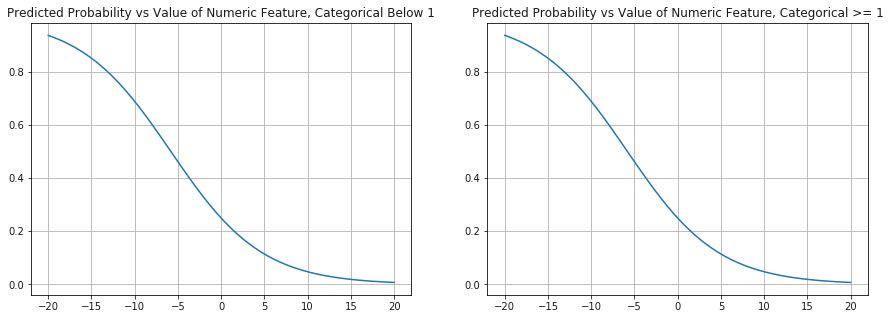

In [12]:
I = np.linspace(-20,20)
P_C0 = 1/(1+np.exp(-(W[0]+W[1]*I)))
P_C1 = 1/(1+np.exp(-(W[0]+W[1]*I+W[2])))

# set up figure
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,5))

ax1.plot(I,P_C0)
ax1.set_title('Predicted Probability vs Value of Numeric Feature, Categorical Below 1', color='0.1')
ax1.tick_params(axis='both', colors='0.1')
ax1.grid(True)

ax2.plot(I,P_C0)
ax2.set_title('Predicted Probability vs Value of Numeric Feature, Categorical >= 1', color='0.1')
ax2.tick_params(axis='both', colors='0.1')
ax2.grid(True)

plt.show()

Both curves are bounded between 0 and 1 and decrease as $I_1$ increases. They are nearly identical curves because the coefficient on $C_2$ is small.

Though given our data above we don't seem to be overfitting because the training loss is close to the validation loss, we only have 2 features in this model. If we had many more regularization would make sense to keep coefficient values small. For example, if we use L2 regularization instead we see the estimated coefficient values are all below 1 in magnitude.

# Section 3: Exploratory Analysis of the Dataset
The Criteo click through rate (CTR) advertising data comes as two tab separated text files: train.txt and test.txt.  The data set comes from 7 days of Criteo web traffic, and the data is stored sequentially.  Train.txt is intended for training models, and test.txt for generating predictions on a test set which is scored by Kaggle.   The files have no header information and the categorical information (fields 14-39) are hashed in order to protect Criteo's intellectual property (IP) and anonymize personal identifying information.

In section 1 of this notebook we examined the file sizes and format of the columns.  With these huge file sizes (45 and 6 million records, respectively) we need to take scalability into account in our design. For our EDA and development, we used a 1% random sample of the data in order for processing to be more manageable. (sampleRDD defined above)

The key goals of this EDA are to determine which fields are related to the outcome and how we should handling inputing the fields to our model (i.e. drop, impute missing values, one hot encoding mechanism).


First we parse the data and change it into a Spark data frame.

In [13]:
# parse the fields into integer values
sampleRDD = sampleRDD.map(lambda x: [ConvertNumber(idx, num) for idx,num in enumerate(x.split('\t'))]).cache()

# Create Data Frame
structFieldList = [StructField('field_0', LongType(), True)] +\
                  [StructField('field_' + str(num), FloatType(), True) for num in range(1, 14)] +\
                  [StructField('field_' + str(num), LongType(), True) for num in range(14,40)]
schema = StructType(structFieldList)
sampleDF = spark.createDataFrame(sampleRDD, schema)
numColumns = len(structFieldList)

## Class Balance
It will be very hard to train a model if our data is very imbalanced. Raw CTR data is typically highly imbalanced, because few people click on web ads.  Let's look at the click rate with our training data.

In [14]:
from pyspark.sql.functions import mean as _mean, col

resultList = sampleDF.select(_mean(col('field_0')).alias('mean')).collect()
print('The click rate is: {:.2f}%'.format(resultList[0]['mean']*100))

The click rate is: 25.69%


This is a high click rate (roughly 25%), which matches the fact that the training data was subsampled to increase the positive class.  This will help with our training, as class imbalance can negatively affect the performance of a model.

## Linear Relationship between numerical variables and label
The correlation will point to which numeric features could be predictive of the outcome. Also, if features are highly collinear, we may not want to include them together because the variance of our coefficient estimates may grow too large.

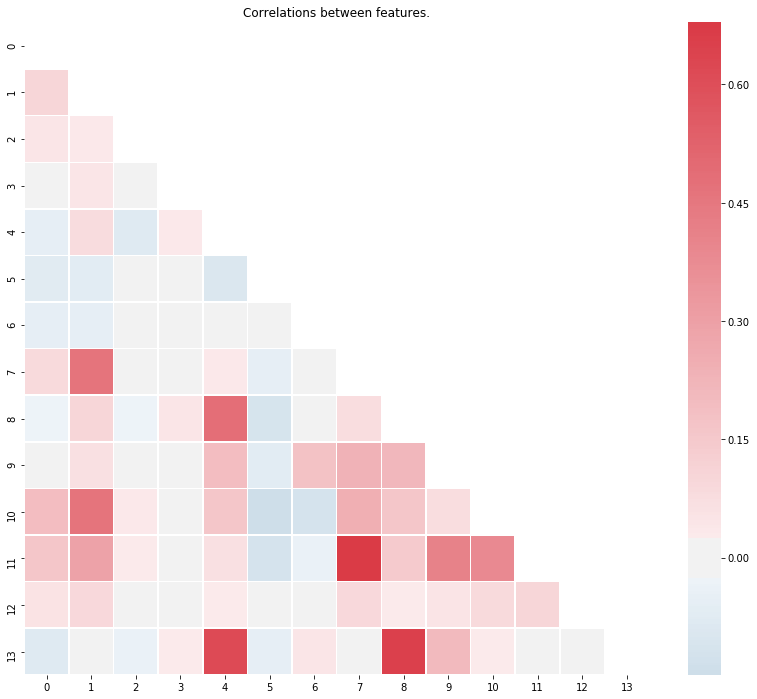

In [15]:
num_corr_fields = 14

corr = np.zeros(shape=(num_corr_fields,num_corr_fields))
testFields = ['field_' + str(num) for num in range(num_corr_fields)]

for iidx in range(len(testFields)):
    for jidx in range(iidx):
        corr[iidx, jidx] = sampleDF.stat.corr(testFields[iidx], testFields[jidx])

plt.figure(figsize=(14,12))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.5)
plt.title("Correlations between features.")
plt.show()

From this, we see that:
* Clicks (field 0) seem to be positively correlated with the following fields:
    * Weakly: 1, 2, 7, and 12
    * Moderately: 10, 11
* The following groups of fields are highly correlated:
    * (1,10,7); (4,13,8); (7,11); (8,13)

The fields with high magnitude correlations with the label (field 0) are likely good ones to put into our logistic regression because they have a linear relationship with the probability of a click.

## Summary Stats, Histograms, and BoxPlots by Label for each Feature

### Summary statistics (especially missing values)
The summary statistics including missing values will give us a sense of how the variable behaves. We cannot pass missing values in as features in our model, so we need to deal with them:
* If there are too many missing values ( >5%) we decided to drop the feature in order to not bias our model.
* For features with a small (<= 5%) number of nulls, we will:
  * Impute the values if the feature is numeric
  * Drop the null observations if the feature is categorical.

### Histograms and Boxplots
Histograms and boxplots will give us a sense of the distribution and cardinality of each variable. We will one hot encode our categorical features. For lower cardinality categorical features, we will have 10 columns representing the 10 most often occurring values and all 0s in these columns will represent any other value. For high cardinality categoricals, we will use a hashing trick to use the `mod` function to randomly assign the categorical values to buckets. We can control the number of buckets to reduce the cardinality of the feature. We don't use the hashing to lower cardinality method for low cardinality categoricals because it could place a lot of the data into one category randomly and make it hard to get a precise estimate of the coefficient.

The different scale of the numeric features reveals that they need to be standardized in order to stabilize our gradient descent methodology. Without standardization, we would traverse the gradient in the direction of the fields with smaller scales too much and those with larger scales too little.

In [16]:
click_data = sampleDF.select('field_0').rdd.flatMap(lambda x: x).collect()
totalRows = sampleDF.count()

def columnEDA(field_num, df):

    # Describe the columns
    if field_num < 14:
        fieldList = ['field_'+str(field_num)]
        df.describe(fieldList).show()
        
    # Distinct counts for this column
    fieldStr = "field_" + str(field_num)
    groupedDF = df.filter(fieldStr + " is not NULL").groupBy(fieldStr).count()
    count_list = groupedDF.select('count').rdd.flatMap(lambda x: x).collect()
    print('Number of distinct values: {}'.format(len(count_list)))
    
    # Number of null values
    num_null_values = df.select(fieldStr).rdd.flatMap(lambda x: x).filter(lambda x: x == None).count()
    print('Percent null values: {:.2f}%'.format((float(num_null_values) /totalRows)*100))
    
    # Plot the histogram
    plt.figure(figsize=(16,4))
    count_list = df.select(fieldStr).rdd.flatMap(lambda x: x).filter(lambda x: x != None).collect()
    plt.hist(count_list, bins=100)
    plt.title("Distribution of unique " + fieldStr + " values")
    plt.show()
    
    # Plot field v. click
    if field_num != 0:
        field_data = df.select(fieldStr).rdd.flatMap(lambda x: x).collect()
        
        plt.figure(figsize=(16,4))
        sns.boxplot(field_data, click_data, orient='h', linewidth=.5)
        plt.title(fieldStr + " v. click")
        plt.show()

### Numeric Fields

#### Field 1

+-------+-----------------+
|summary|          field_1|
+-------+-----------------+
|  count|           250226|
|   mean|3.533401804768489|
| stddev|   9.553016235911|
|    min|              0.0|
|    max|           1011.0|
+-------+-----------------+

Number of distinct values: 222
Percent null values: 45.41%


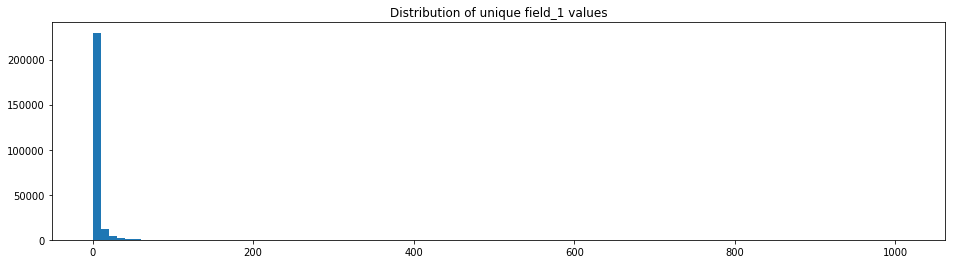

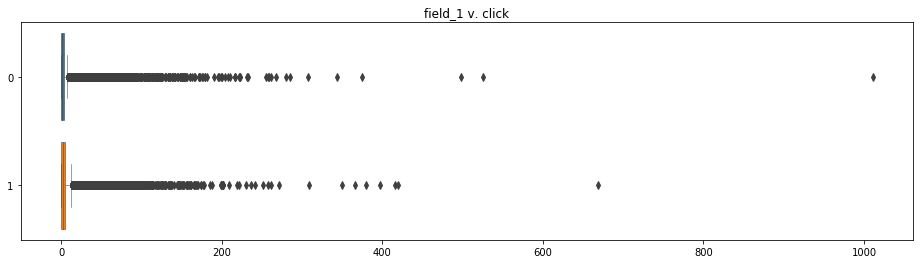

In [20]:
columnEDA(1, sampleDF)

Discussion:
* 45% of the values are null
* Drop the field

#### Field 2

+-------+-----------------+
|summary|          field_2|
+-------+-----------------+
|  count|           458406|
|   mean|106.5369868631737|
| stddev| 392.908087001365|
|    min|             -2.0|
|    max|          19503.0|
+-------+-----------------+

Number of distinct values: 3921
Percent null values: 0.00%


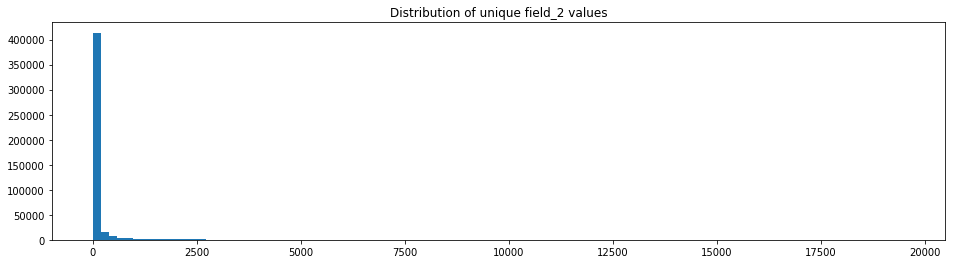

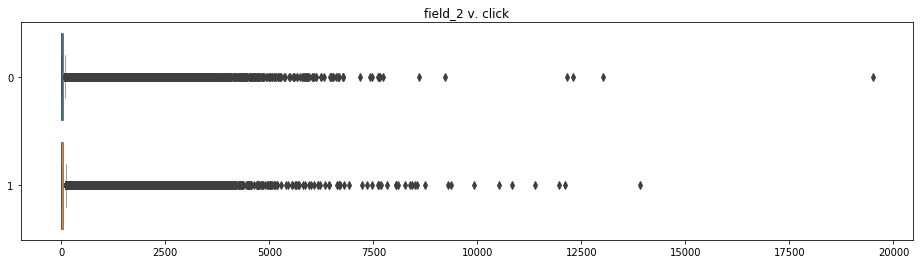

In [21]:
columnEDA(2, sampleDF)

Discussion:
* This field has no null values
* Keep and scale the field

#### Field 3

+-------+------------------+
|summary|           field_3|
+-------+------------------+
|  count|            360471|
|   mean|27.009182430764195|
| stddev| 396.2546237304598|
|    min|               0.0|
|    max|           65535.0|
+-------+------------------+

Number of distinct values: 1243
Percent null values: 21.36%


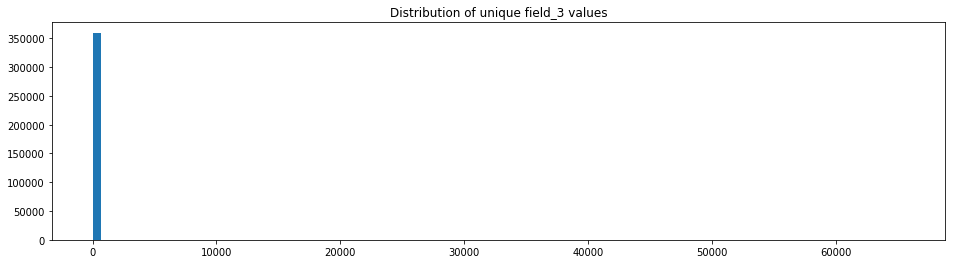

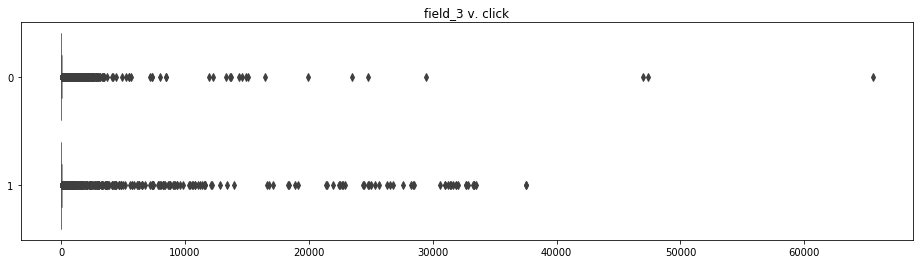

In [22]:
columnEDA(3, sampleDF)

Discussion:
* This field has 21% null values
* Drop the field

#### Field 4

+-------+----------------+
|summary|         field_4|
+-------+----------------+
|  count|          359211|
|   mean|7.31401321229027|
| stddev|8.73669015608748|
|    min|             0.0|
|    max|           427.0|
+-------+----------------+

Number of distinct values: 131
Percent null values: 21.64%


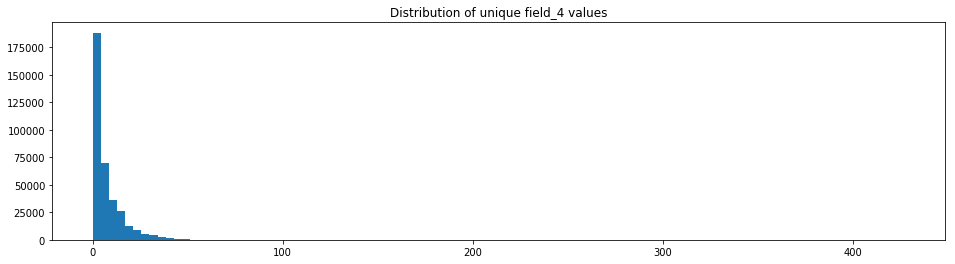

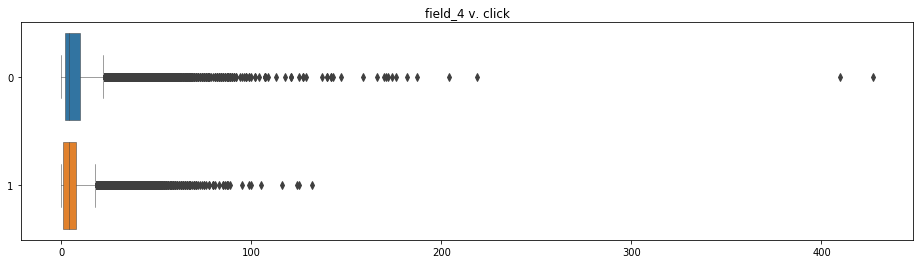

In [23]:
columnEDA(4, sampleDF)

Discussion:
* This field has 22% null values
* Drop the field

#### Field 5

+-------+------------------+
|summary|           field_5|
+-------+------------------+
|  count|            446573|
|   mean|18622.860446108476|
| stddev| 69782.51863169692|
|    min|               0.0|
|    max|         2633976.0|
+-------+------------------+

Number of distinct values: 53587
Percent null values: 2.58%


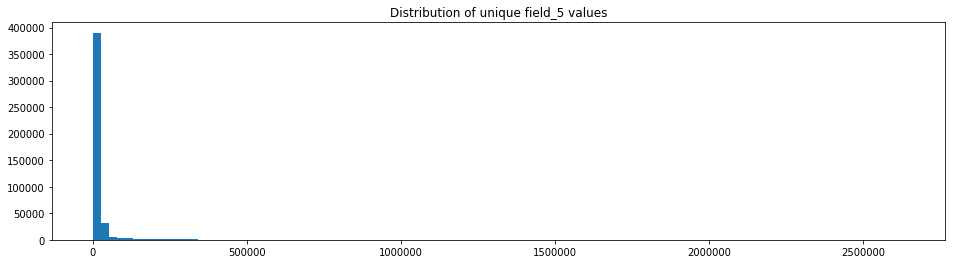

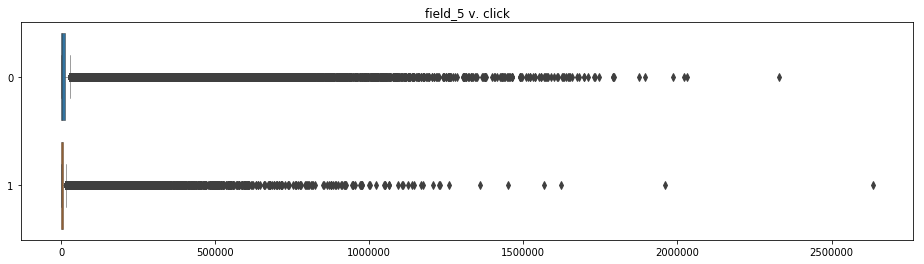

In [24]:
columnEDA(5, sampleDF)

Discussion:
* This field has 3% null values
* Impute with the mean and scale

#### Field 6

+-------+------------------+
|summary|           field_6|
+-------+------------------+
|  count|            355936|
|   mean|116.27206576463185|
| stddev| 405.6191480689997|
|    min|               0.0|
|    max|           87452.0|
+-------+------------------+

Number of distinct values: 3070
Percent null values: 22.35%


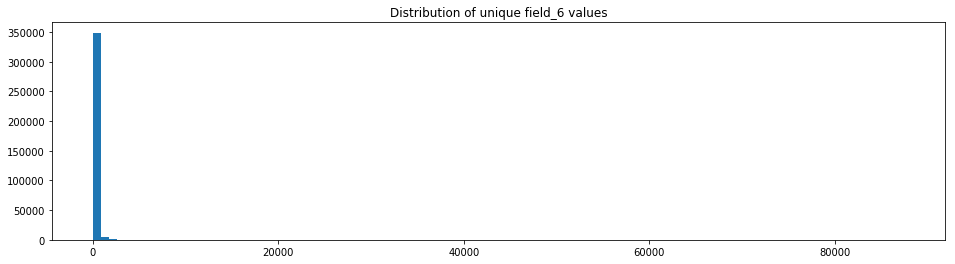

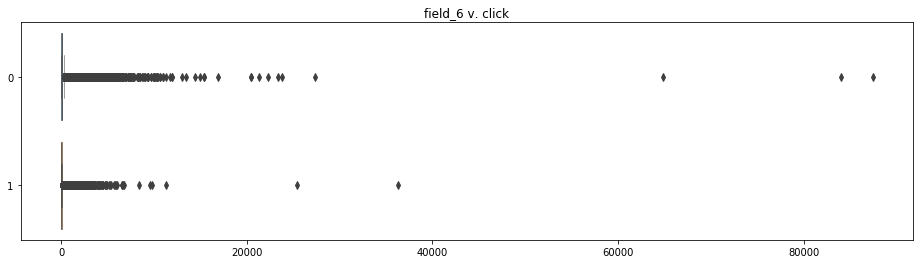

In [25]:
columnEDA(6, sampleDF)

Discussion:
* This field has 22% null values
* Drop the field

#### Field 7

+-------+------------------+
|summary|           field_7|
+-------+------------------+
|  count|            438749|
|   mean|16.387428803256533|
| stddev| 66.61942766697219|
|    min|               0.0|
|    max|           12309.0|
+-------+------------------+

Number of distinct values: 1108
Percent null values: 4.29%


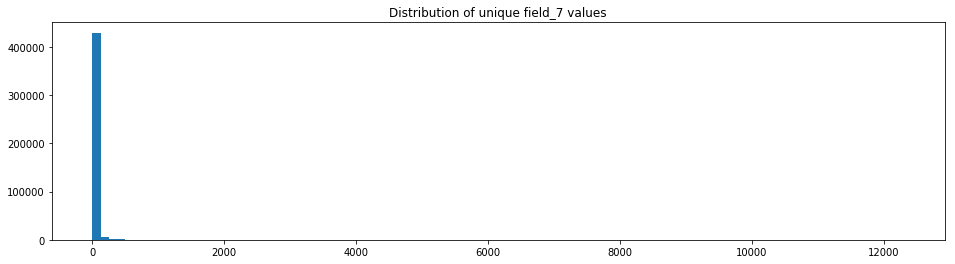

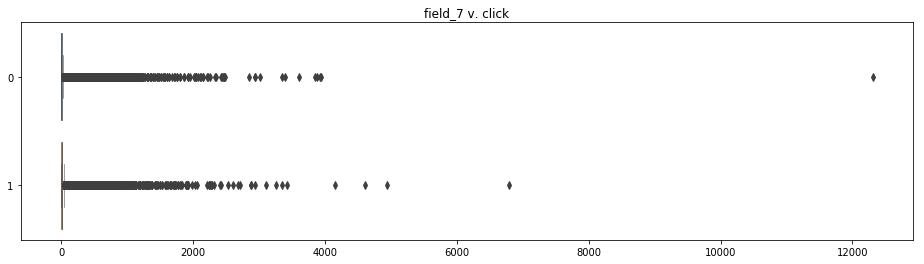

In [26]:
columnEDA(7, sampleDF)

Discussion:
* This field has 4% null values
* Impute with the mean and scale

#### Field 8

+-------+------------------+
|summary|           field_8|
+-------+------------------+
|  count|            458168|
|   mean|12.481976043721954|
| stddev|16.257188379641548|
|    min|               0.0|
|    max|            3444.0|
+-------+------------------+

Number of distinct values: 226
Percent null values: 0.05%


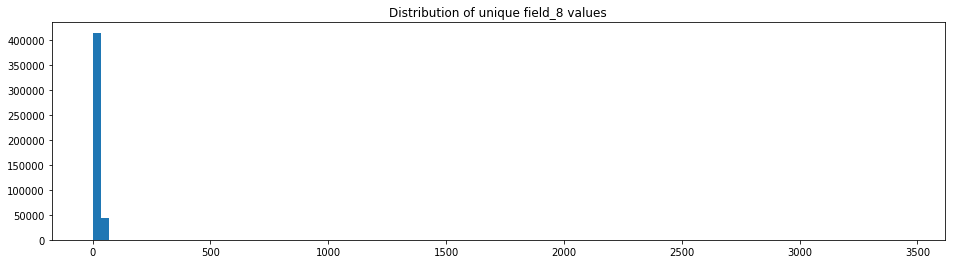

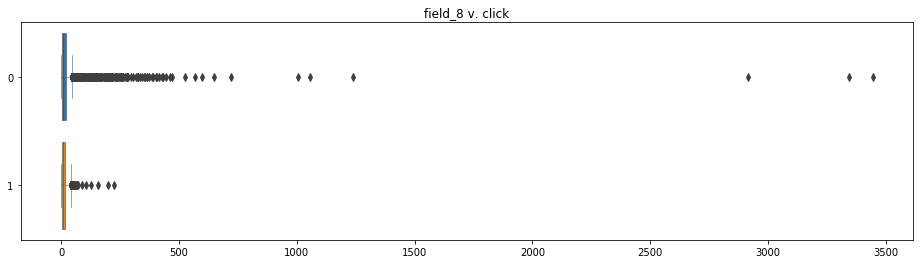

In [27]:
columnEDA(8, sampleDF)

Discussion:
* This field has < 1% null values
* Impute with the mean and scale

#### Field 9

+-------+------------------+
|summary|           field_9|
+-------+------------------+
|  count|            438749|
|   mean|105.99618460668856|
| stddev| 220.4951527519252|
|    min|               0.0|
|    max|           13879.0|
+-------+------------------+

Number of distinct values: 2497
Percent null values: 4.29%


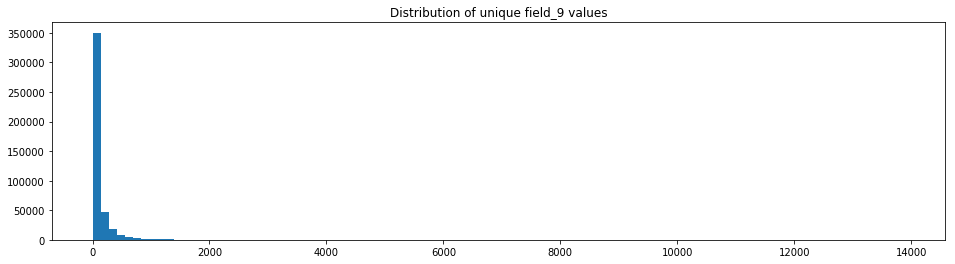

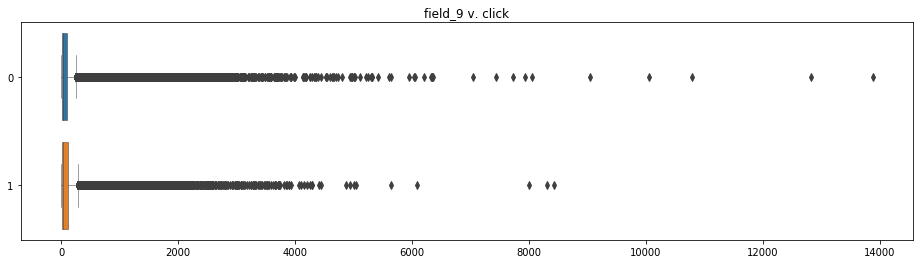

In [28]:
columnEDA(9, sampleDF)

Discussion:
* This field has 4% null values
* Impute with the mean and scale

#### Field 10

+-------+------------------+
|summary|          field_10|
+-------+------------------+
|  count|            250226|
|   mean|0.6194719973144277|
| stddev|0.6821149359557124|
|    min|               0.0|
|    max|               8.0|
+-------+------------------+

Number of distinct values: 9
Percent null values: 45.41%


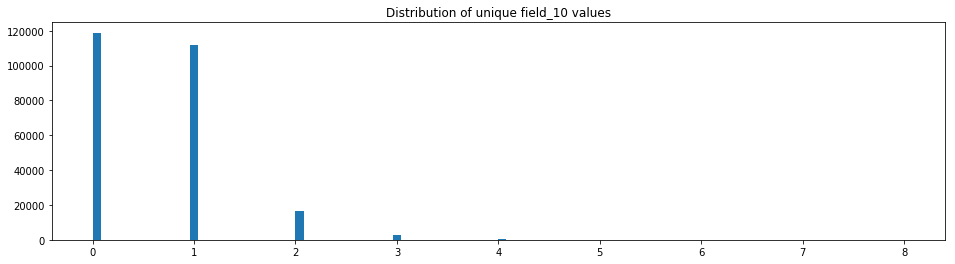

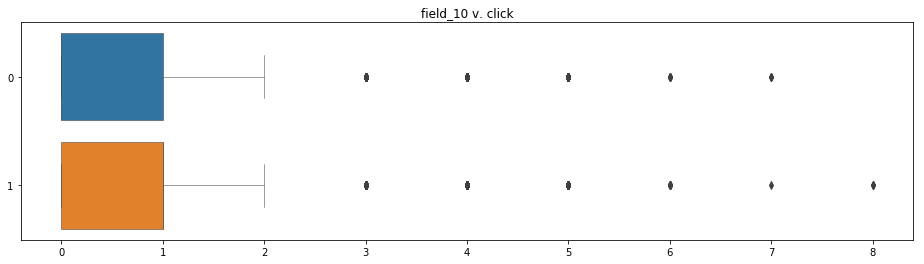

In [29]:
columnEDA(10, sampleDF)

Discussion:
* This field has 45% null values
* Drop this field

#### Field 11

+-------+------------------+
|summary|          field_11|
+-------+------------------+
|  count|            438749|
|   mean|2.7333236087147776|
| stddev| 5.162205207408435|
|    min|               0.0|
|    max|             144.0|
+-------+------------------+

Number of distinct values: 111
Percent null values: 4.29%


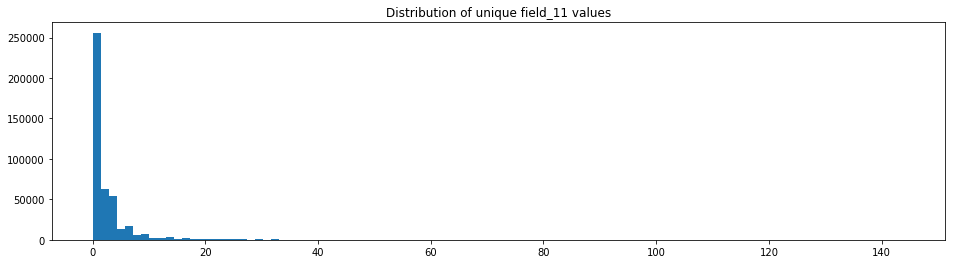

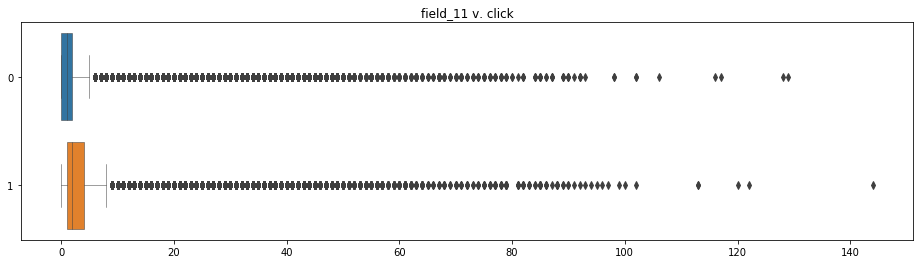

In [30]:
columnEDA(11, sampleDF)

Discussion:
* This field has 4% null values
* Impute with the mean and scale

#### Field 12

+-------+------------------+
|summary|          field_12|
+-------+------------------+
|  count|            107464|
|   mean|0.9732561602024864|
| stddev| 4.808448593577541|
|    min|               0.0|
|    max|             264.0|
+-------+------------------+

Number of distinct values: 122
Percent null values: 76.56%


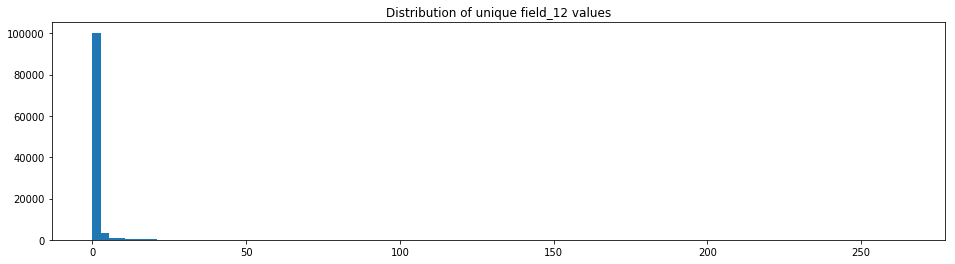

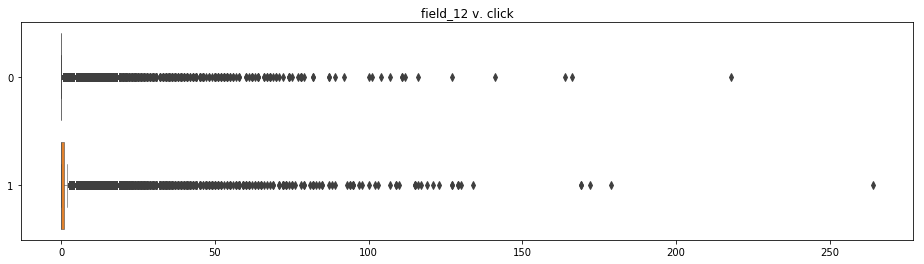

In [31]:
columnEDA(12, sampleDF)

Discussion:
* This field has 77% null values
* Drop the field

#### Field 13

+-------+------------------+
|summary|          field_13|
+-------+------------------+
|  count|            359211|
|   mean| 8.179184379097522|
| stddev|15.359400635356668|
|    min|               0.0|
|    max|            3383.0|
+-------+------------------+

Number of distinct values: 259
Percent null values: 21.64%


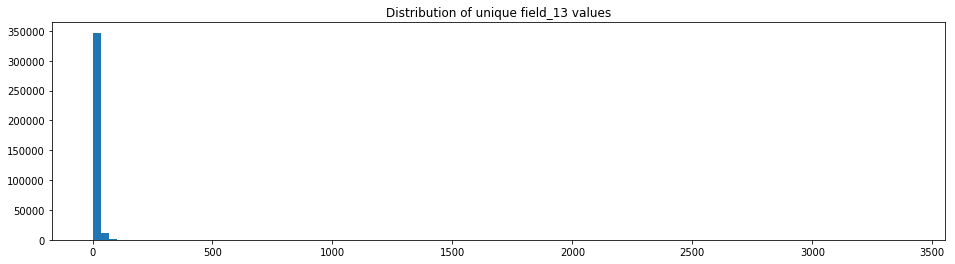

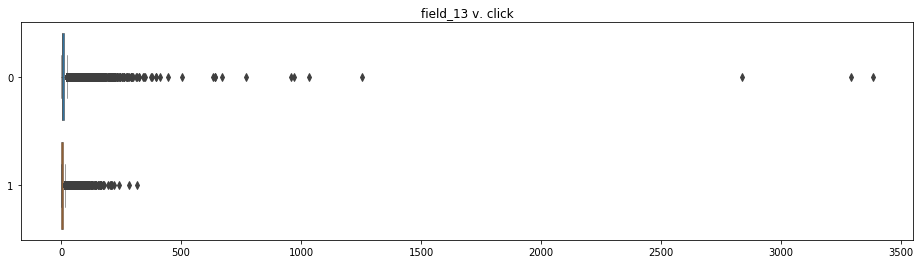

In [32]:
columnEDA(13, sampleDF)

Discussion:
* This field has 22% null values
* Drop the field

#### Field 14

Number of distinct values: 999
Percent null values: 0.00%


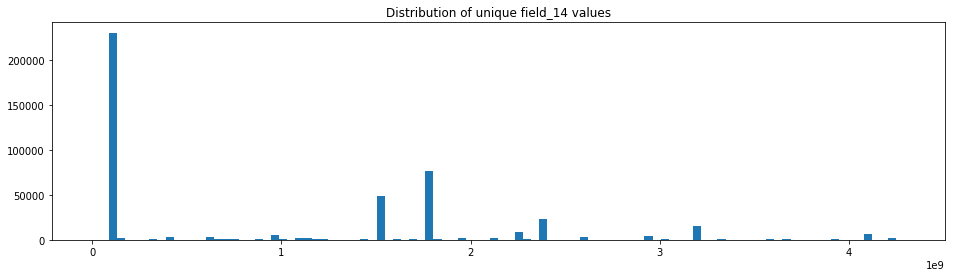

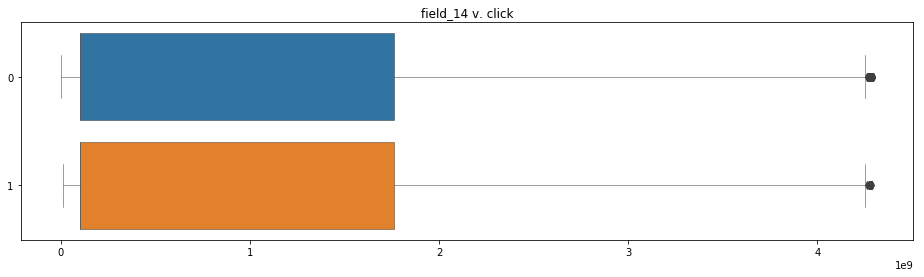

In [33]:
columnEDA(14, sampleDF)

Discussion:
* This field has no null values
* It has a moderate amount of distinct values, so it can be OHE using the top values

#### Field 15

Number of distinct values: 546
Percent null values: 0.00%


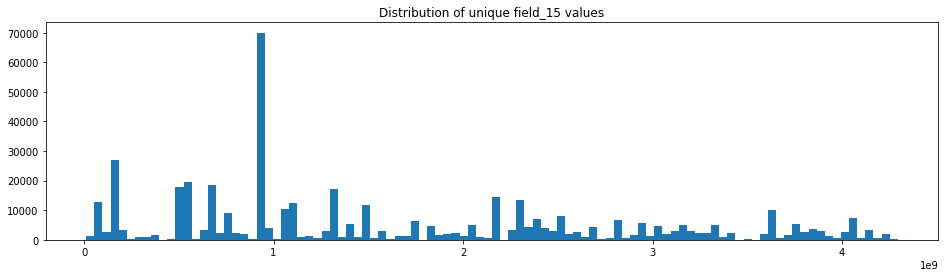

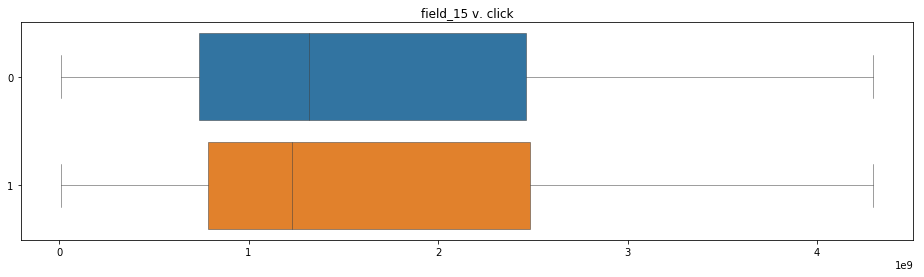

In [34]:
columnEDA(15, sampleDF)

Discussion:
* This field has no null values
* It has a moderate amount of distinct values, so it can be OHE using the top values

#### Field 16

Number of distinct values: 181328
Percent null values: 3.40%


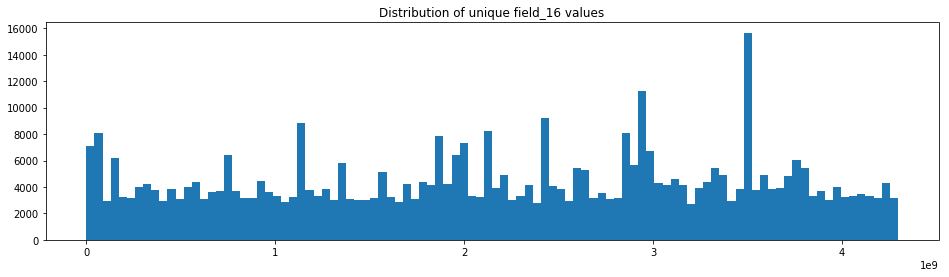

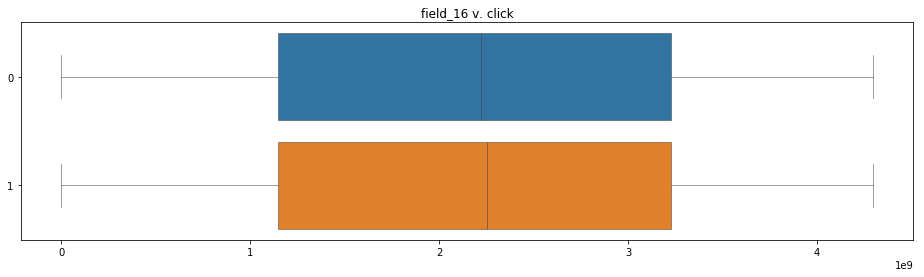

In [35]:
columnEDA(16, sampleDF)

Discussion:
* This field has 3% null values
* It has a large amount of distinct values, so hash to a lower cardinality

#### Field 17

Number of distinct values: 79432
Percent null values: 3.40%


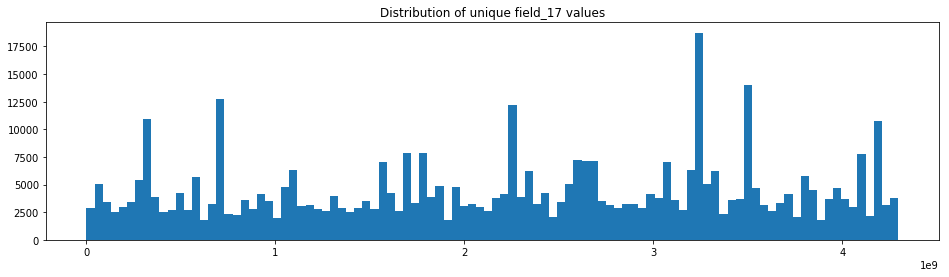

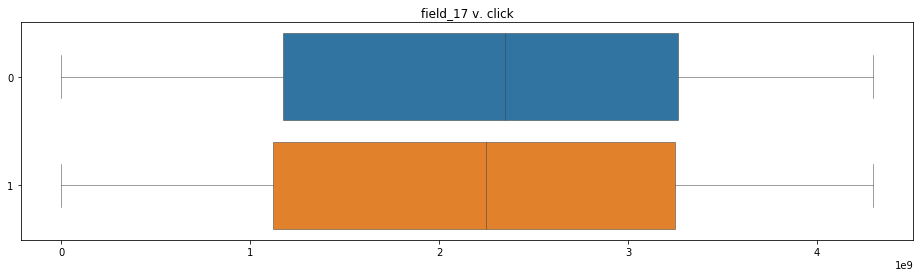

In [36]:
columnEDA(17, sampleDF)

Discussion:
* This field has 3% null values
* It has a large amount of distinct values, so hash to a lower cardinality

#### Field 18

Number of distinct values: 220
Percent null values: 0.00%


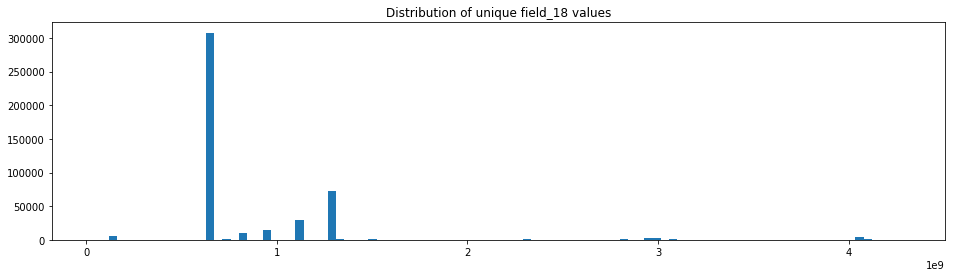

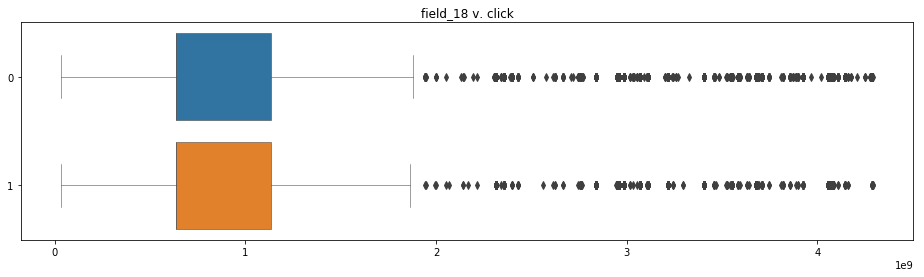

In [37]:
columnEDA(18, sampleDF)

Discussion:
* This field has no null values
* It has a moderate amount of distinct values, so it can be OHE using the top values

#### Field 19

Number of distinct values: 13
Percent null values: 12.05%


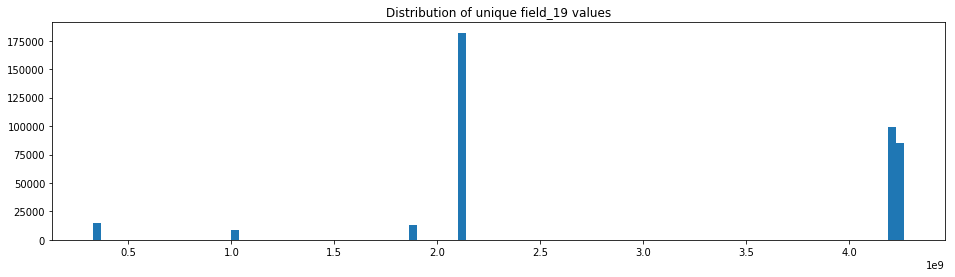

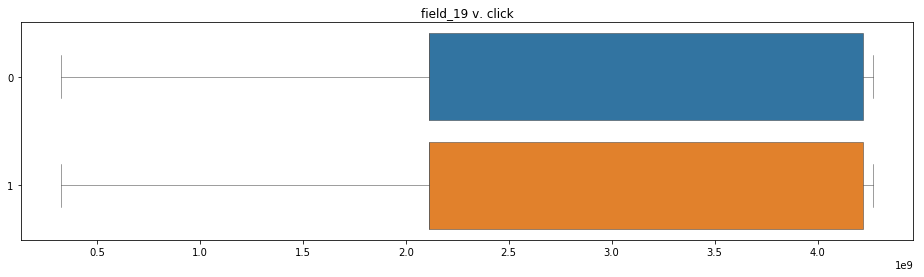

In [38]:
columnEDA(19, sampleDF)

Discussion:
* This field has 12% null values
* Drop the field

#### Field 20

Number of distinct values: 10399
Percent null values: 0.00%


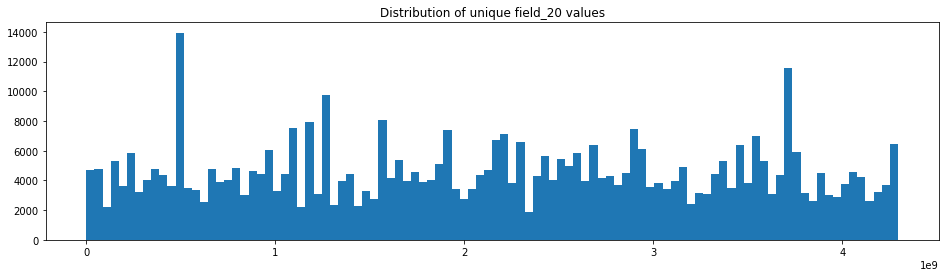

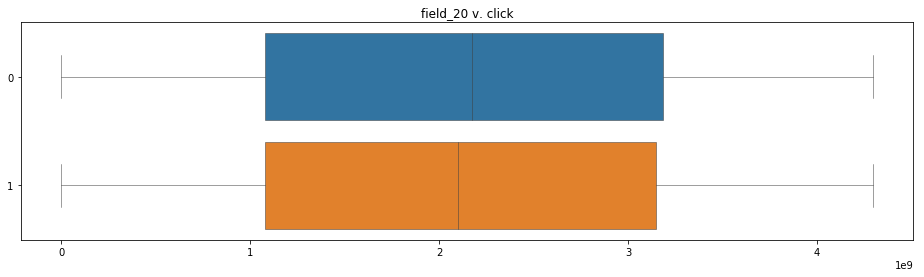

In [39]:
columnEDA(20, sampleDF)

Discussion:
* This field has no null values
* It has a large amount of distinct values, so hash to a lower cardinality

#### Field 21

Number of distinct values: 450
Percent null values: 0.00%


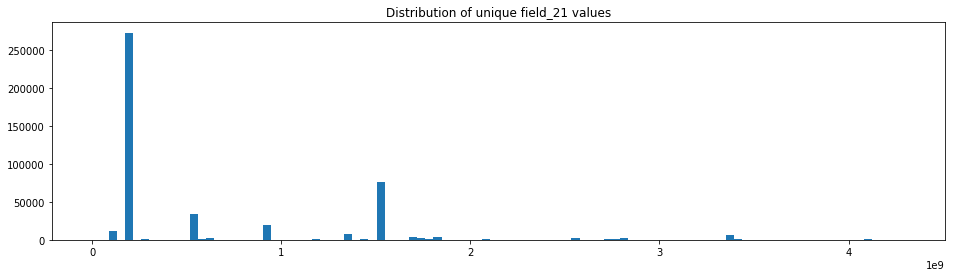

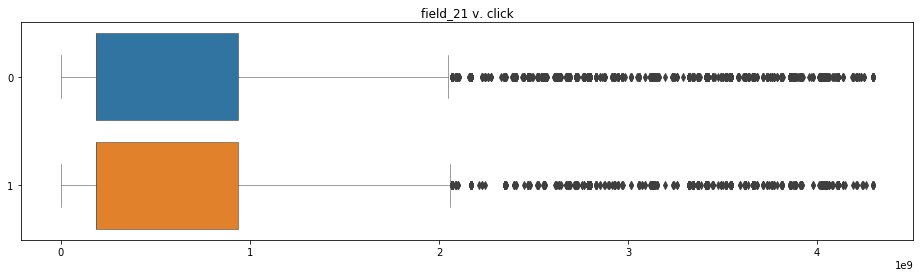

In [40]:
columnEDA(21, sampleDF)

Discussion:
* This field has no null values
* It has a moderate amount of distinct values, so it can be OHE using the top values

#### Field 22

Number of distinct values: 3
Percent null values: 0.00%


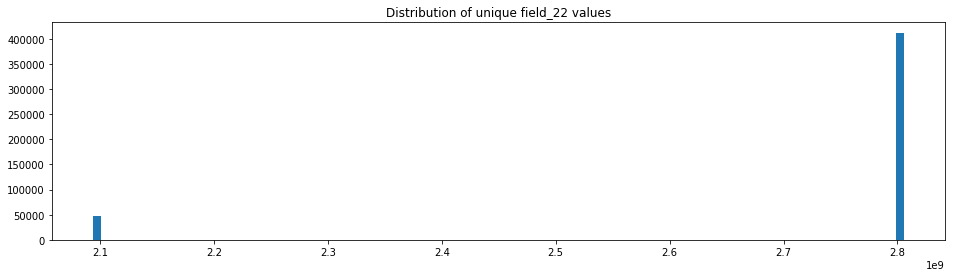

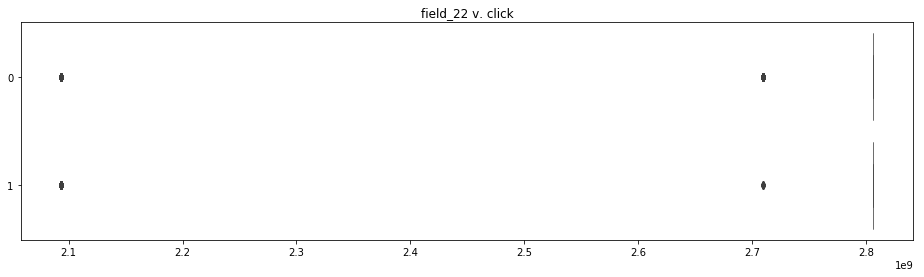

In [41]:
columnEDA(22, sampleDF)

Discussion:
* This field has no null values
* It has a small amount of distinct values, so it can be OHE using the top values

#### Field 23

Number of distinct values: 23541
Percent null values: 0.00%


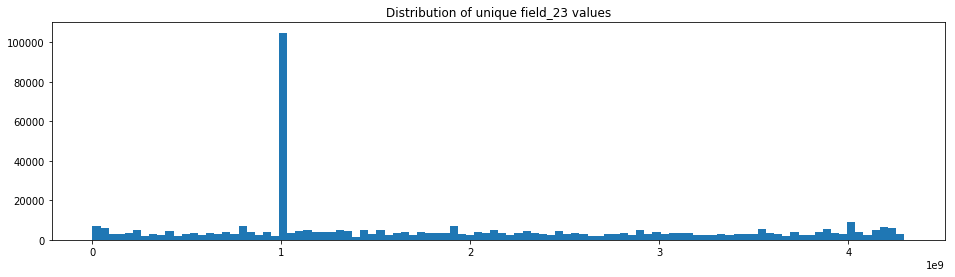

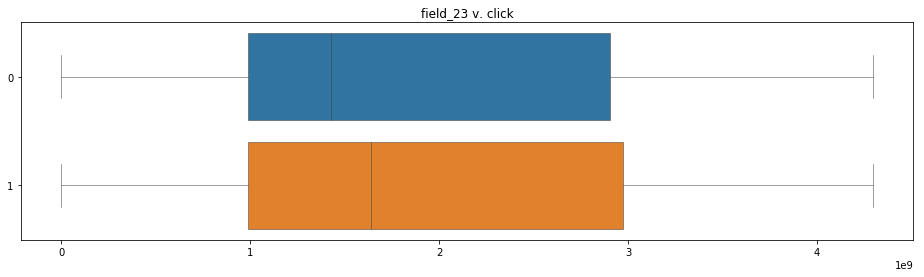

In [42]:
columnEDA(23, sampleDF)

Discussion:
* This field has no null values
* It has a large amount of distinct values, so hash to a lower cardinality

#### Field 24

Number of distinct values: 4652
Percent null values: 0.00%


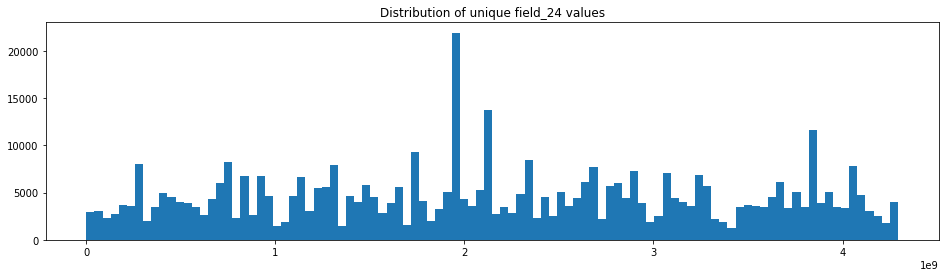

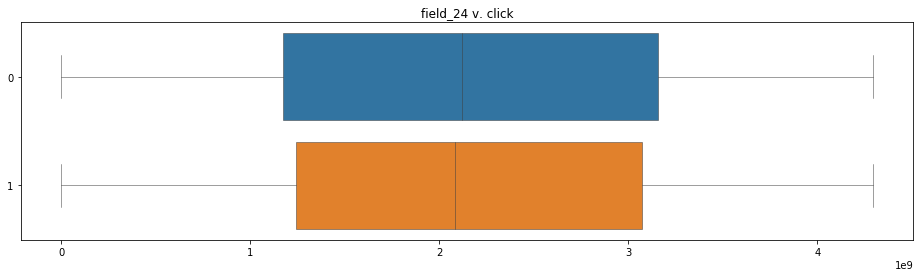

In [43]:
columnEDA(24, sampleDF)

Discussion:
* This field has no null values
* It has a moderate amount of distinct values, so it can be OHE using the top values

#### Field 25

Number of distinct values: 163240
Percent null values: 3.40%


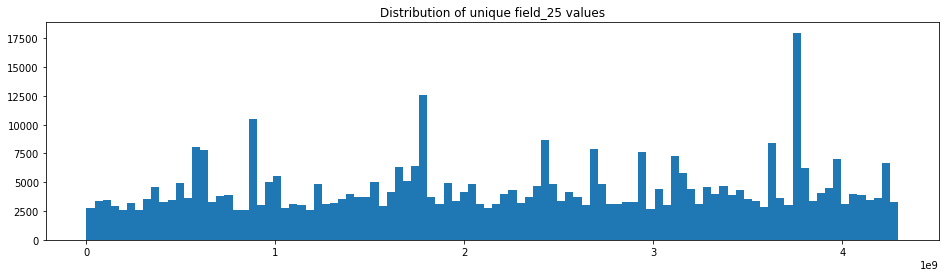

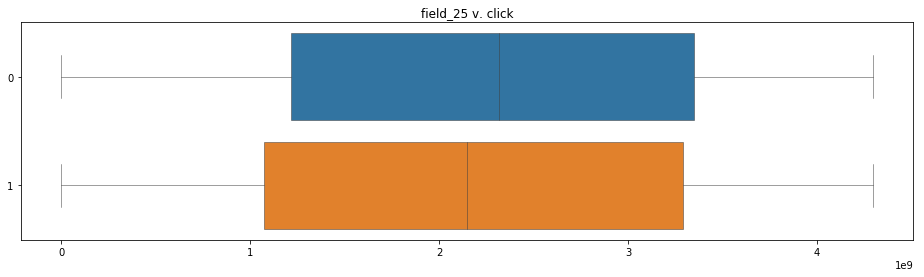

In [44]:
columnEDA(25, sampleDF)

Discussion:
* This field has 3% null values
* It has a large amount of distinct values, so hash to a lower cardinality

#### Field 26

Number of distinct values: 3105
Percent null values: 0.00%


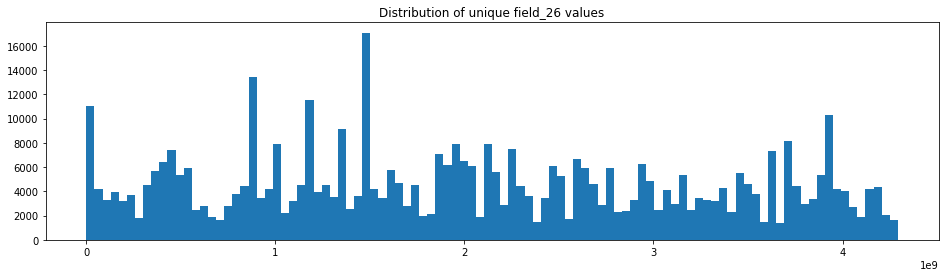

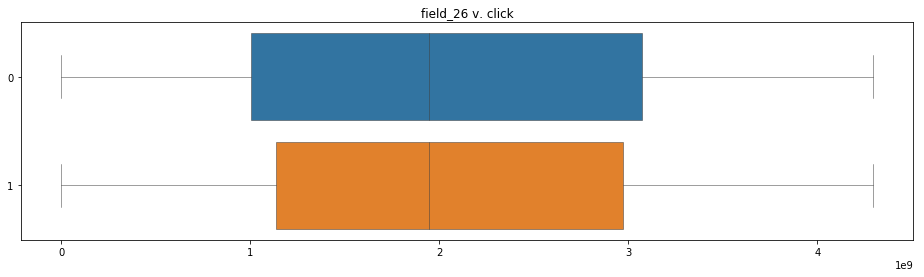

In [45]:
columnEDA(26, sampleDF)

Discussion:
* This field has no null values
* It has a moderate amount of distinct values, so it can be OHE using the top values

#### Field 27

Number of distinct values: 26
Percent null values: 0.00%


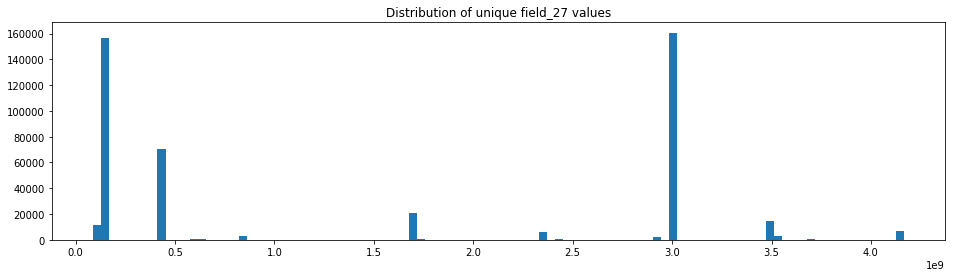

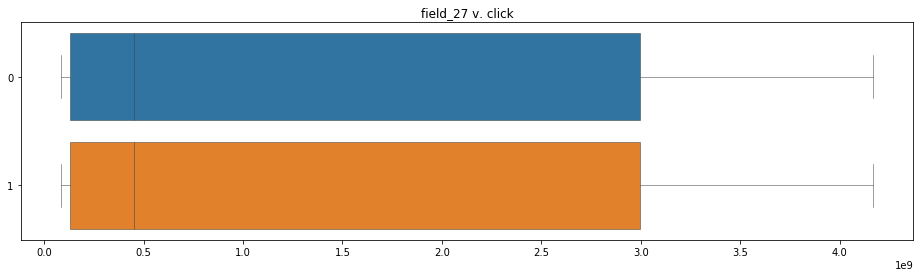

In [46]:
columnEDA(27, sampleDF)

Discussion:
* This field has no null values
* It has a small amount of distinct values, so it can be OHE using the top values

#### Field 28

Number of distinct values: 8050
Percent null values: 0.00%


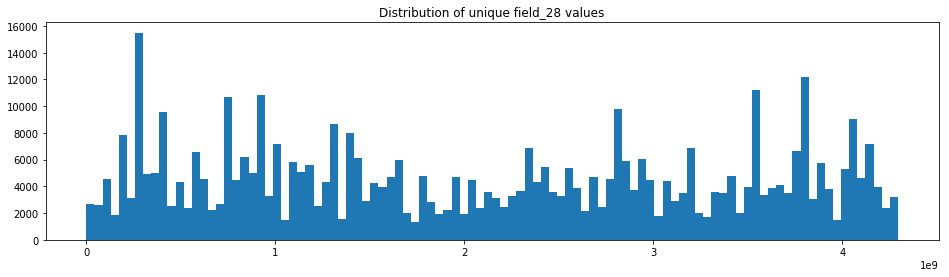

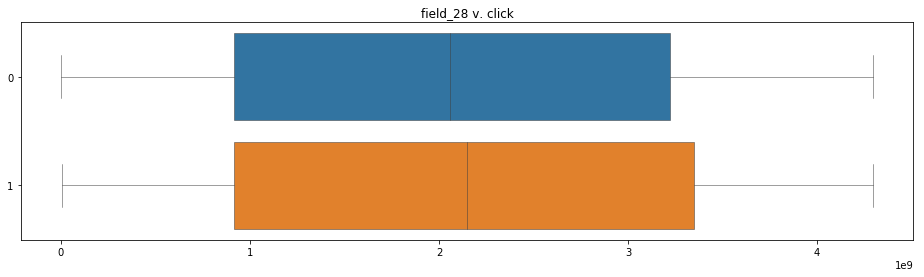

In [47]:
columnEDA(28, sampleDF)

Discussion:
* This field has no null values
* It has a moderate amount of distinct values, so it can be OHE using the top values

#### Field 29

Number of distinct values: 128476
Percent null values: 3.40%


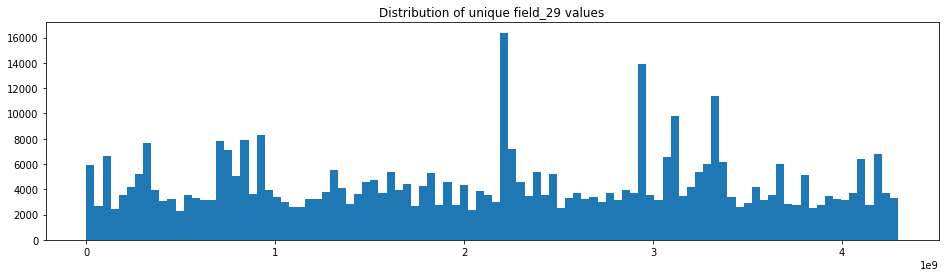

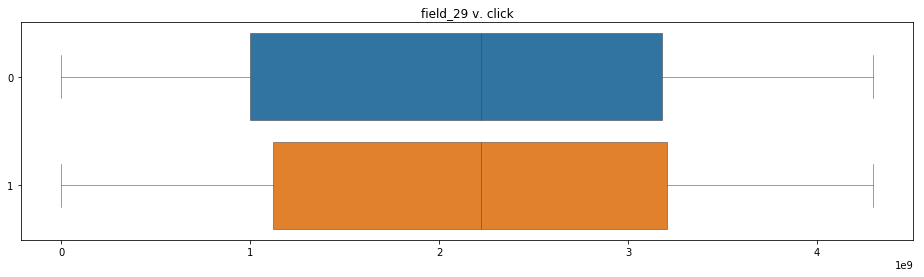

In [48]:
columnEDA(29, sampleDF)

Discussion:
* This field has 3% null values
* It has a large amount of distinct values, so hash to a lower cardinality

#### Field 30

Number of distinct values: 10
Percent null values: 0.00%


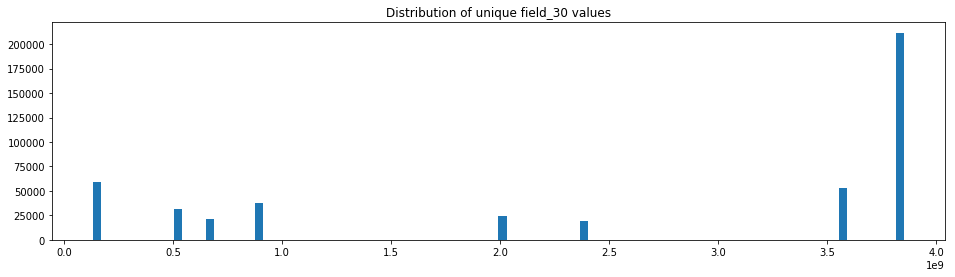

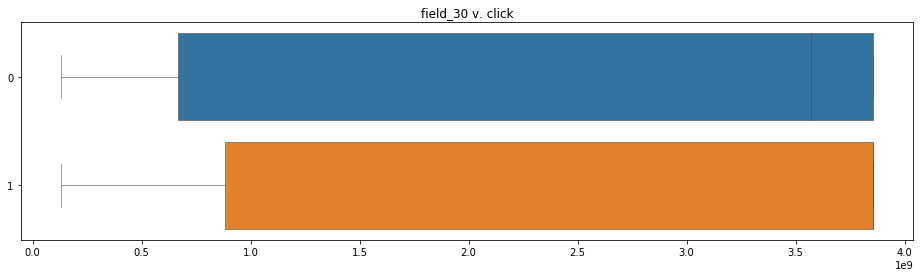

In [49]:
columnEDA(30, sampleDF)

Discussion:
* This field has no null values
* It has a small amount of distinct values, so it can be OHE using the top values

#### Field 31

Number of distinct values: 3608
Percent null values: 0.00%


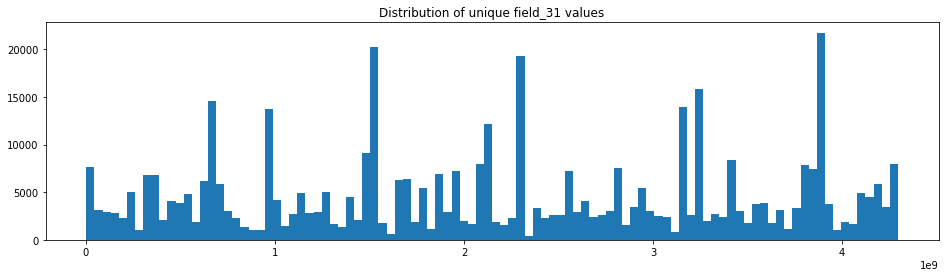

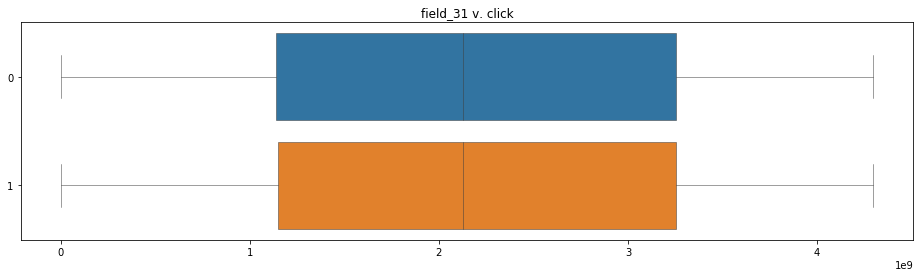

In [50]:
columnEDA(31, sampleDF)

Discussion:
* This field has no null values
* It has a moderate amount of distinct values, so it can be OHE using the top values

#### Field 32

Number of distinct values: 1686
Percent null values: 43.98%


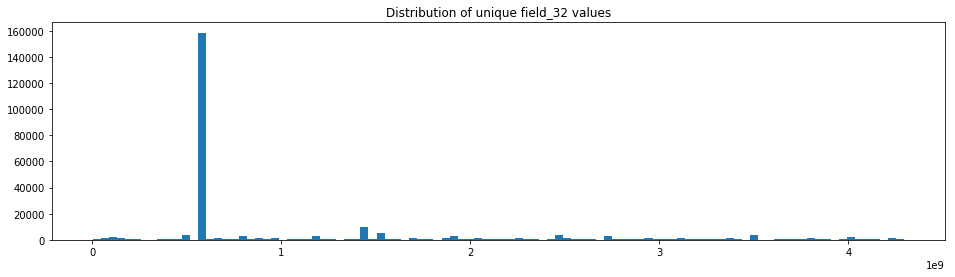

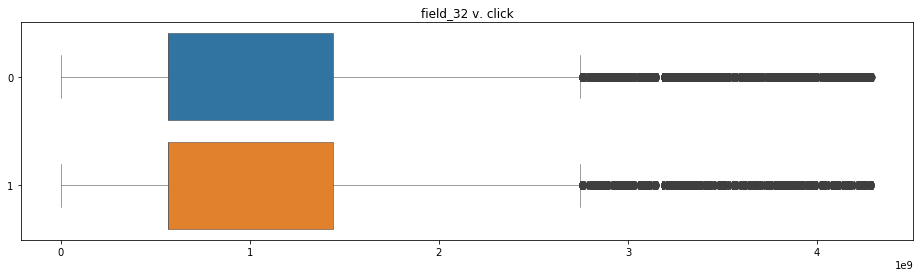

In [51]:
columnEDA(32, sampleDF)

Discussion:
* This field has 44% null values, so drop the field

#### Field 33

Number of distinct values: 3
Percent null values: 43.98%


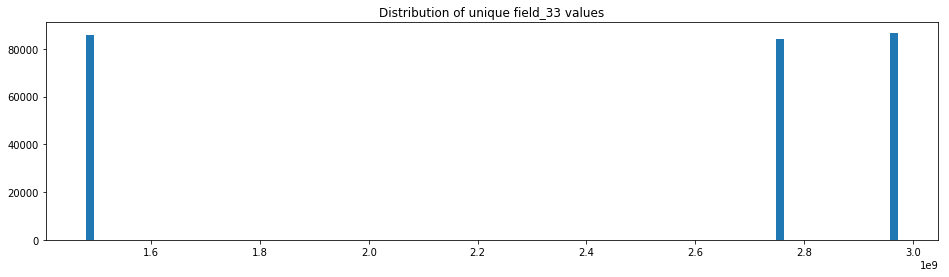

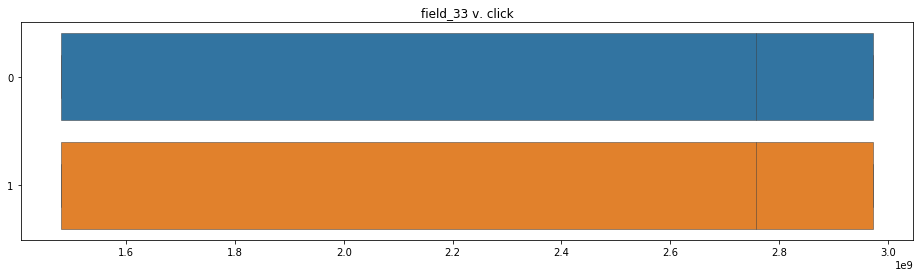

In [52]:
columnEDA(33, sampleDF)

Discussion:
* This field has 44% null values, so drop the field

#### Field 34

Number of distinct values: 148810
Percent null values: 3.40%


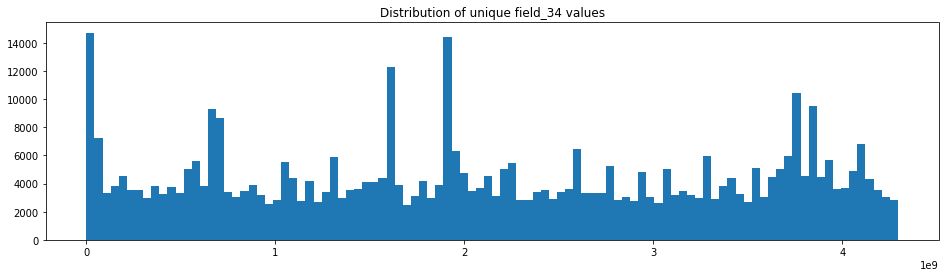

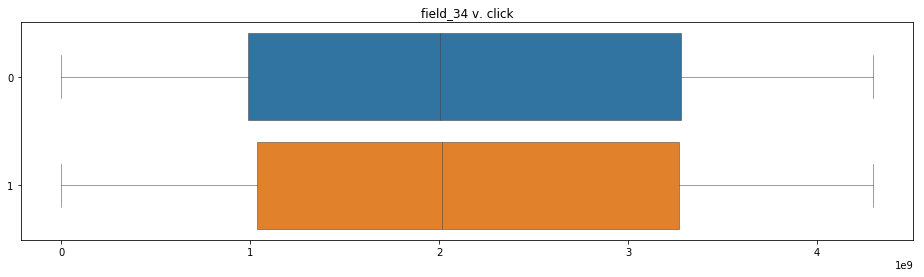

In [53]:
columnEDA(34, sampleDF)

Discussion:
* This field has 3% null values
* It has a large amount of distinct values, so hash to a lower cardinality

#### Field 35

Number of distinct values: 13
Percent null values: 76.21%


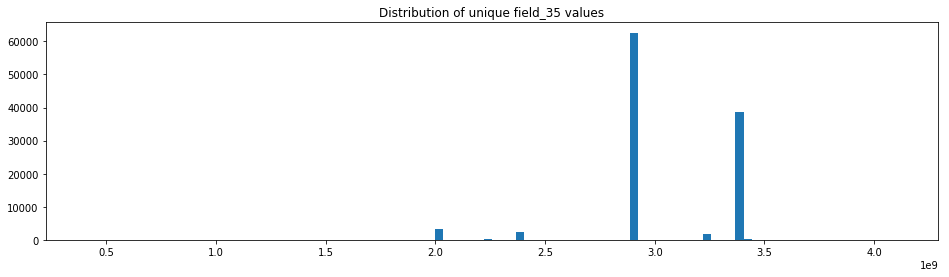

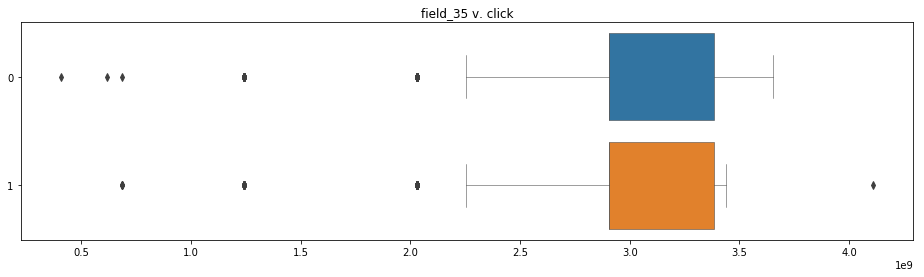

In [54]:
columnEDA(35, sampleDF)

Discussion:
* This field has 76% null values, so drop the field

#### Field 36

Number of distinct values: 14
Percent null values: 0.00%


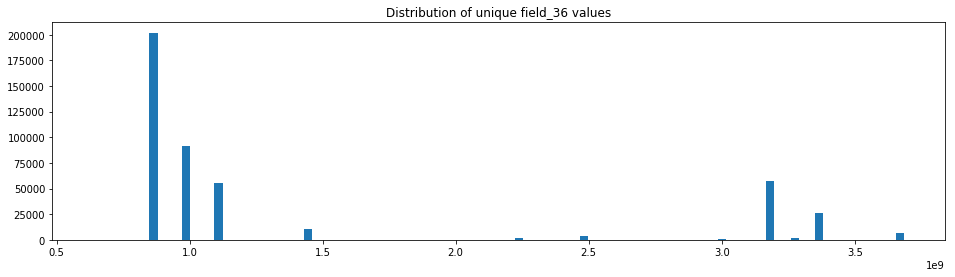

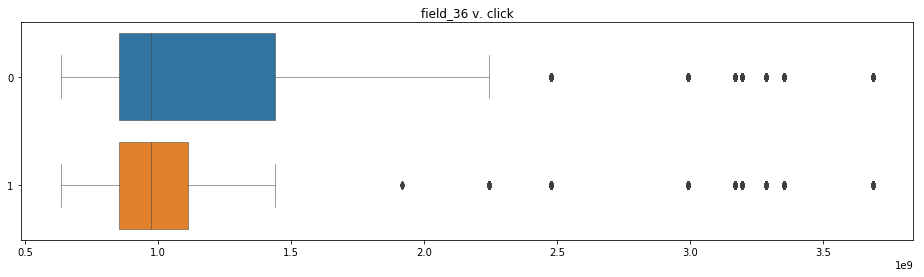

In [55]:
columnEDA(36, sampleDF)

Discussion:
* This field has no null values
* It has a small amount of distinct values, so it can be OHE using the top values

#### Field 37

Number of distinct values: 29361
Percent null values: 3.40%


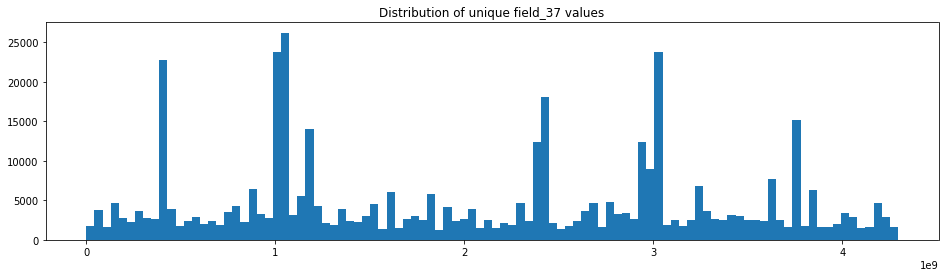

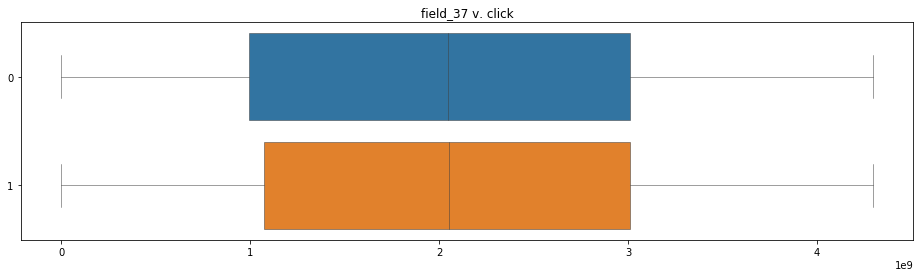

In [56]:
columnEDA(37, sampleDF)

Discussion:
* This field has 3% null values
* It has a large amount of distinct values, so hash to a lower cardinality

#### Field 38

Number of distinct values: 64
Percent null values: 43.98%


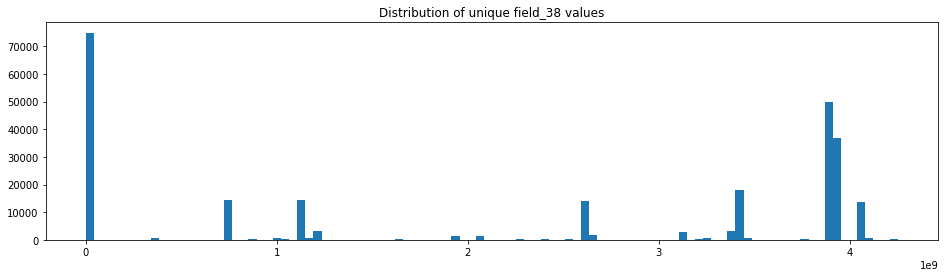

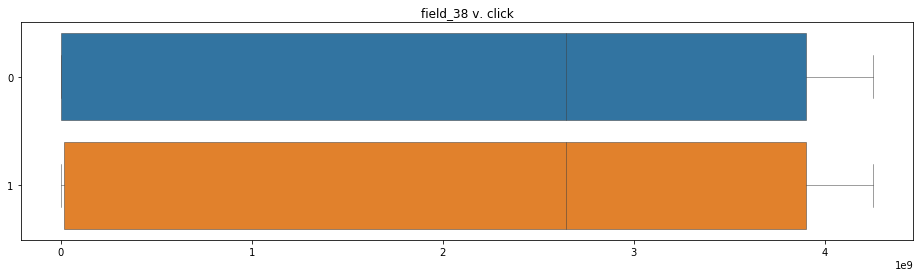

In [57]:
columnEDA(38, sampleDF)

Discussion:
* This field has 44% null values, so drop the field

#### Field 39

Number of distinct values: 21898
Percent null values: 43.98%


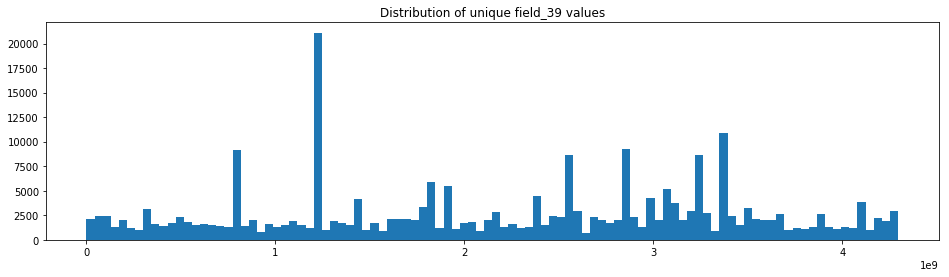

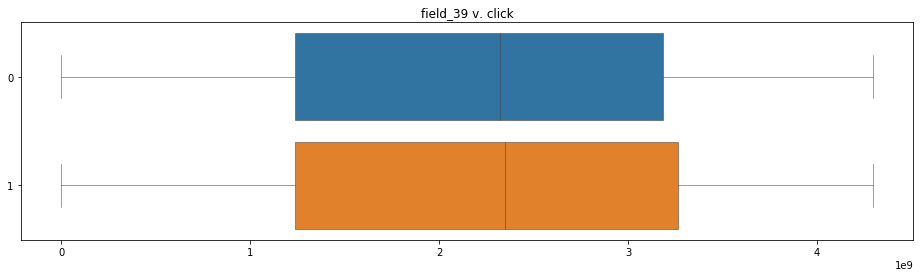

In [58]:
columnEDA(39, sampleDF)

Discussion:
* This field has 44% null values, so drop the field

### Anticipated Challenges Based on EDA
Based on the EDA, we expect the following challenges:
* The training set is over 45 million records, so we will need to design with scalability in mind.  The code will need to run on a cluster.
* The data set has various levels of missing data.  We need to determine the best way of handling missing data, whether it be dropping fields or observations.  Also we need to decide what threshold to use when making those decisions.
* The categorical data can be handled in different ways, such as OHE or feature hashing.  Given either approach, we still need to decide on the best cardinality for the output encoding.

## Data Cleaning
Next we need to actually process the data using the decisions from our EDA in the discussion notes above. We also explicitly partition the data to make sure that we are getting efficiency gains from increased parallelization. We chose 32 partitions because we used 8 nodes with 4 cpus each.



In [18]:
# Set up partitioning to optimize parallelization.
sampleRDD = sampleRDD.repartition(numParts)

In [72]:
# import full training set - adjust file path as necessary. Text file is publicly accessible
# on the project Google Cloud Storage bucket.
fullDataRDD = sc.textFile('gs://gptv01/data/261final/train.txt')

# parse the fields into integer values
fullDataRDD = fullDataRDD.map(lambda x: [ConvertNumber(idx, num) for idx,num in enumerate(x.split('\t'))]).cache()
fullDataRDD = fullDataRDD.repartition(numParts)

In [20]:
# Create trainRDD and testRDD.
# Schema is defined at the beginning of the EDA section

# 1 percent sample
trainRDD, testRDD =(sampleRDD.randomSplit([0.8,0.2], seed = 1))

trainDF = spark.createDataFrame(trainRDD, schema)
testDF = spark.createDataFrame(testRDD, schema)

In [98]:
# Full dataset
trainFullRDD, testFullRDD =(fullDataRDD.randomSplit([0.8,0.2], seed = 1))

trainFullDF = spark.createDataFrame(trainFullRDD, schema)
testFullDF = spark.createDataFrame(testFullRDD, schema)

In [21]:
# Confirming the structure of sampleDF
sampleDF.take(1)

[Row(field_0=0, field_1=1.0, field_2=3.0, field_3=1.0, field_4=1.0, field_5=1369.0, field_6=2.0, field_7=2.0, field_8=3.0, field_9=2.0, field_10=0.0, field_11=1.0, field_12=0.0, field_13=1.0, field_14=1761418852, field_15=3254796695, field_16=1512877717, field_17=685319864, field_18=2839202569, field_19=4268462821, field_20=3141504557, field_21=185940084, field_22=2805916944, field_23=4202497943, field_24=3473172404, field_25=4290934987, field_26=2649559723, field_27=131152527, field_28=989018656, field_29=4233361500, field_30=666926038, field_31=3335004735, field_32=None, field_33=None, field_34=3979734419, field_35=None, field_36=974593739, field_37=1338774367, field_38=None, field_39=None)]

In [22]:
# Confirming that trainDF has the same structure as sampleDF and can actually be read.
trainDF.take(1)

[Row(field_0=1, field_1=None, field_2=-1.0, field_3=None, field_4=None, field_5=15096.0, field_6=2.0, field_7=3.0, field_8=0.0, field_9=10.0, field_10=None, field_11=2.0, field_12=None, field_13=None, field_14=98275684, field_15=2514670391, field_16=2467059328, field_17=3735442566, field_18=633879704, field_19=1869454312, field_20=1569166990, field_21=529118562, field_22=2805916944, field_23=2814810478, field_24=3669313445, field_25=2906020792, field_26=2058058128, field_27=2995026422, field_28=396606680, field_29=2721717745, field_30=3854202482, field_31=2064055038, field_32=2011453853, field_33=2972002973, field_34=3137050398, field_35=None, field_36=851920782, field_37=658061279, field_38=737579441, field_39=2025955028)]

In [99]:
# Confirming that trainFullDF has the same structure as sampleDF and can actually be read.
trainFullDF.take(1)

[Row(field_0=0, field_1=0.0, field_2=-1.0, field_3=None, field_4=None, field_5=1332.0, field_6=10.0, field_7=3.0, field_8=18.0, field_9=19.0, field_10=0.0, field_11=2.0, field_12=None, field_13=None, field_14=98275684, field_15=2026690974, field_16=37298001, field_17=3116771753, field_18=633879704, field_19=2114768079, field_20=3775232298, field_21=185940084, field_22=2805916944, field_23=810526190, field_24=449619283, field_25=597108122, field_26=915530723, field_27=131152527, field_28=372192041, field_29=3548315276, field_30=3854202482, field_31=3890844107, field_32=568184265, field_33=1480633834, field_34=3054605081, field_35=None, field_36=1111468905, field_37=1168872648, field_38=3904386055, field_39=2973715166)]

## Drop Fields with too many Nulls

In [100]:
fields_to_drop = ['field_1','field_3','field_4','field_6','field_10',
    'field_12','field_13','field_19','field_32','field_33',
    'field_35','field_38','field_39']

for f in fields_to_drop:
    trainDF = trainDF.drop(f)
    testDF = testDF.drop(f)

In [101]:
for f in fields_to_drop:
    trainFullDF = trainFullDF.drop(f)
    testFullDF = testFullDF.drop(f)

## Scale Continuous Data and Impute the Mean
For the numeric integer fields, we scale them to be mean 0 and unit variance so that gradient descent algorithm is stablized. We also impute missing values with the mean because we believe the average to be a good central measure when multiplied by the coefficient.

In [102]:
def scaleRow(row):
    """ Scales data by removing the mean and dividing by the standard deviation
    """
    rowDict = row.asDict()
    
    # Scale by subtracting the meann, and dividing by the stdDev
    for field in broadcastScaleDict.value.keys():
        rowDict[field] = float(rowDict[field]-broadcastScaleDict.value[field][0])/broadcastScaleDict.value[field][1]

    return pyspark.sql.Row(**rowDict)

In [103]:
def scaleDataFrame_fit(fields, df):
    """Finds the mean and standard deviation of fields in df
        These are used in scaleRow to scale rows
    """
    #get mean and stdDev
    summaryDF = df.select(fields).describe().withColumnRenamed('summary', 'summary_col').cache()
    
    meanRow = summaryDF.filter(summaryDF.summary_col == 'mean').first()
    stddevRow = summaryDF.filter(summaryDF.summary_col == 'stddev').first()
    
    #store the mean and stdDev for each field in dict with field as key
    #scaleDict is defined outside of this function
    for field in fields:  
        scaleDict[field] = (float(meanRow[field]), float(stddevRow[field]))

In [104]:
def scaleDataFrame_transform(df):
    return df.rdd.map(scaleRow).toDF()

In [105]:
def imputeWithMean(field, traindf,testdf):
    """Fills missing values of field in with the mean of field
    """
    fieldMean = broadcastScaleDict.value[field][0]
    return traindf.fillna(fieldMean, [field]),testdf.fillna(fieldMean, [field])

In [106]:
# 1 percent Sample

#create dict to hold key = which_field, value = (mean, stdDev)
scaleDict = {}

# Save original column order
originalColumnOrderTrain = trainDF.columns

# get the means and stdevs
scaleDataFrame_fit(['field_2','field_5','field_7','field_8','field_9','field_11'], trainDF)

broadcastScaleDict = sc.broadcast(scaleDict)

# fill nulls of continuous variables
fields_to_impute = ['field_5','field_7','field_8','field_9','field_11']
for m in fields_to_impute:
    trainDF,testDF = imputeWithMean(m, trainDF,testDF)

# scale the data with the mean and stdevs that were calculated
trainDF = scaleDataFrame_transform(trainDF)
testDF = scaleDataFrame_transform(testDF)

# Reset to original column order
trainDF = trainDF.select(originalColumnOrderTrain)
testDF = testDF.select(originalColumnOrderTrain)

In [107]:
# Full Dataset

#create dict to hold key = which_field, value = (mean, stdDev)
scaleDict = {}

# Save original column order
originalColumnOrderTrain = trainFullDF.columns

# get the means and stdevs
scaleDataFrame_fit(['field_2','field_5','field_7','field_8','field_9','field_11'], trainFullDF)

# broadcast the dict so it is available
broadcastScaleDict = sc.broadcast(scaleDict)

# fill nulls of continuous variables with mean
fields_to_impute = ['field_5','field_7','field_8','field_9','field_11']
for m in fields_to_impute:
    trainFullDF,testFullDF = imputeWithMean(m, trainFullDF,testFullDF)

# scale the data with the mean and stdevs that were calculated
trainFullDF = scaleDataFrame_transform(trainFullDF)
testFullDF = scaleDataFrame_transform(testFullDF)

# Reset to original column order
trainFullDF = trainFullDF.select(originalColumnOrderTrain)
testFullDF = testFullDF.select(originalColumnOrderTrain)

## One-hot Categorical Vars
The logistic regression will only accept numerical inputs. Therefore we must one hot encode the categorical values into a number of columns of 0s and 1s. We have two one hot encoding mechanisms:
1. For fields with low cardinality, take the top fields and one hot encode those with one column each. All other columns are represented by all 0s in these columns.
2. For fields with high cardinality, take the mod of their integer transformed hash to distribute the values into 5 buckets. Null values are placed in bucket one (note because we don't know anything about the fields and they came from a hash is is basically equivalent to randomly placing Nulls into one of the buckets). Then there are 4 columns to represent these with the 5th bucket picked up when the values of all 4 columns are 0.

Our one hot encoding process is as follows:
* `ohe_fit` populates `valueDict` which helps us encode the low cardinality fields. `valueDict` has keys of field names and values that are dictionaries with keys that are the true top values from the field and values that are the index of the column to encode them in.
* `cardinalityDict` tells the one hot encoding mechanism in convertRowToArray how many fields need to be added for that categorical (equal to the N of the top N fields)
* `featureHashingDict` has field names as keys and the cardinality they should be reduced to as values. 
* `convertRowToArray` uses the above dicts and checks which type of one hot encoding to apply and outputs the tuple (numpy array of features, labels) that can be fed into the algorithm.

In [108]:
def convertRowToArray(row):
    """Converts Categoricals to One Hot Encodings by two methodologies
        and outputs tuples of (numpy array of features, label)
    """
    rowDict = row.asDict()
    
    # X will hold all features (numerical and categorical)
    #    they are appended throughout this function
    X = np.array([])
    
    # Iterate over fields in the row
    for field in rowDict.keys():
        
        # If the field is categorical and to be OHE using the top values
        if field in broadcastValueDict.value:
            
            if rowDict[field] not in broadcastValueDict.value[field]:
                
                # If the value is not found in the categories for that field (rare/unknown),
                # then the encoding is all zeros
                X = np.append(X, np.zeros(broadcastCardinalityDict.value[field]))
                
            else:
    
                # If the value is found in the categories for that field      
                ohe = np.zeros(broadcastCardinalityDict.value[field])
                
                # Look up the value in the dictionary for this category (it is an index)
                index = broadcastValueDict.value[field][rowDict[field]]
                ohe[index] = 1
                X = np.append(X, ohe)
                
        # If the field is categorical and to be feature hashed to a lower cardinality
        elif field in broadcastFeatureHashingDict.value:
            
            # Get the cardinality and create a zeros array.
            #   Note, to encode 3 values, use 3-1 columns, e.g. (00, 10, 01)
            cardinality = broadcastFeatureHashingDict.value[field]
            hashEnc = np.zeros(cardinality-1)
            
            # Encode the field % cardinality
            if rowDict[field]: # if not a null value check which index
                index = rowDict[field]%cardinality # mod to lower cardinality
                if index < cardinality-1:
                    hashEnc[index] = 1
            
            X = np.append(X, hashEnc)
    
        # Set the actual value (Y) if the field is field_0
        elif field == 'field_0':
            Y = rowDict[field]
            
        # If the field one of the numeric ones, then just use the existing value
        else:
            X = np.append(X, rowDict[field])
    
    return (X, Y)

In [109]:
def ohe_fit(field, topN, df):
    """Populate valueDict with
    keys of field names and values that are 
    dictionaries with keys that are the true top values from the field
        and values that are the index of the column to encode them in.
    
    Args:
        field (str): fieldname
        topN (int): number of top fields to encode in columns
        df (spark dataframe): data to get top values from
    
    Returns:
        updated valueDict
    """

    # Find the frequency of items in the category
    fieldFreqRDD = df.rdd.map(lambda x: (x[field], 1)).\
                          reduceByKey(lambda x, y: x+y)

    # Save the topN values in the dictionary associated with this field
    validValuesDict = {}
    index=0
    for value in fieldFreqRDD.takeOrdered(topN, key=lambda x: -x[1]):
        validValuesDict[value[0]] = index
        index += 1

    # Use the top N frequent values
    valueDict[field] = validValuesDict

In [110]:
def ohe_transform(df):
    oheRDD = df.rdd.map(lambda row: convertRowToArray(row))
    return oheRDD

In [111]:
#create dicts to hold top category values
valueDict = {}

cardinalityDict = {
    'field_14': 10,
    'field_15': 10,
    'field_18': 10,
    'field_21': 10,
    'field_22': 3,
    'field_24': 10,
    'field_26': 10,
    'field_27': 10,
    'field_28': 10,
    'field_30': 10,
    'field_31': 10,
    'field_36': 10
}

In [112]:
# set feature hashing dict to identify the features that should be hashed to lower cardinality
featureHashingDict = {
    'field_16':5,
    'field_17':5,
    'field_20':5,
    'field_23':5,
    'field_25':5,
    'field_29':5,
    'field_34':5,
    'field_37':5
}

In [113]:
# 1 Percent Sample
#loop through fields to update dicts
for field, cardinality in cardinalityDict.items():
    ohe_fit(field, cardinality, trainDF)

In [ ]:
# Full Dataset
#loop through fields to update dicts
for field, cardinality in cardinalityDict.items():
    ohe_fit(field, cardinality, trainFullDF)

In [114]:
broadcastValueDict = sc.broadcast(valueDict)
broadcastCardinalityDict = sc.broadcast(cardinalityDict)
broadcastFeatureHashingDict = sc.broadcast(featureHashingDict)

In [39]:
#convert categorical vals to OHE
trainRDD = ohe_transform(trainDF)
testRDD = ohe_transform(testDF)

In [40]:
trainRDD.cache()
testRDD.cache()

PythonRDD[414] at RDD at PythonRDD.scala:48

In [115]:
#convert categorical vals to OHE
trainFullRDD = ohe_transform(trainFullDF)
testFullRDD = ohe_transform(testFullDF)

In [116]:
trainFullRDD.cache()
testFullRDD.cache()

PythonRDD[9117] at RDD at PythonRDD.scala:48

# Section 4: Algorithm Implementation

In this section we train the logistic regression via gradient descent with both L2 and L1 regularization.

In [42]:
def logloss(dataRDD, W):
    """
    Calculates the mean log loss from an RDD of (np.array features, labels)
    and a weights array W
    """
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))
    loss = (augmentedData.
            map(lambda x: (np.clip(1 / (1 + np.exp(-1*W @ x[0])), 1e-15, 1.0 - 1e-15), x[1])).
            map(lambda x: -1*np.log(x[0]) if x[1]==1.0 else -1*np.log(1-x[0])).mean())
    return loss

In [43]:
def GDUpdate(dataRDD, W, learningRate = 0.05, regType = None, regParam = 0):
    """
    Perform one gradient descent step/update.
    Args:
        dataRDD - records are tuples of (features_array, y)
        W       - (array) model coefficients with bias at index 0
        regType - whether to perform 'l2' or 'l1' or No (None) regression
        regParam - the tuneable amount of regularization to be done
    Returns:
        new_model - (array) updated coefficients, bias at index 0
    """
    # add a bias 'feature' of 1 at index 0
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1])).cache()
    
    # use negative log likelihood to keep it descent
    grad = augmentedData.map(lambda x: -x[0]*(x[1] - (1/(1+np.exp(-1*np.dot(W, x[0])))))).mean()
    if regType=='l2':
        grad[1:] += 2 * regParam * W[1:]
    elif regType=='l1':
        grad[1:] += regParam * np.sign(W[1:])

    new_model = W - learningRate * grad 
   
    return new_model

In [44]:
trainRDD.first()[0].shape[0]

151

First we use trainRDD (80% sample of the subsample of the data) to get better initialization values to feed into the training for the full dataset

In [55]:
# train the logistic regression - L2 regularization
#create initial weights. make them small
#get size of feature space
size = trainRDD.first()[0].shape[0]
W = np.random.uniform(low=-.05,high=.05,size=(size+1,))

print(f"Initial Model: {[round(w,3) for w in W]}")
print(f"Initial Train Loss = {logloss(trainRDD,W)}")
print(f"Initial Held-Out Loss = {logloss(testRDD,W)}")

n_iterations = 100

for i in range(n_iterations):
    print("-----------------------------------------------------")
    print("iteration # {}".format(i))
    iterTime1 = time.time()
    W = GDUpdate(trainRDD, W, learningRate = 1.5, regType = 'l2', regParam = .1)
    print(f"New Model: {[round(w,3) for w in W]}")
    print(f"Train Loss = {logloss(trainRDD,W)}")
    print(f"Held-Out Loss = {logloss(testRDD,W)}")
    iterTime2 = time.time()
    print("Iteration Time = {} seconds".format(iterTime2-iterTime1))

trainingPriorsL2 = W

Initial Model: [0.03, -0.019, 0.017, -0.039, 0.042, -0.002, -0.022, 0.01, -0.006, 0.023, -0.041, -0.036, -0.026, 0.027, -0.046, -0.041, -0.047, 0.041, -0.02, 0.045, -0.048, 0.024, 0.047, 0.022, -0.006, 0.021, -0.015, 0.022, -0.031, 0.046, 0.022, -0.032, -0.039, 0.048, -0.049, -0.012, -0.0, -0.022, 0.046, 0.026, 0.048, -0.035, -0.042, 0.037, -0.05, 0.048, -0.031, -0.022, -0.045, 0.012, -0.049, 0.039, 0.008, -0.011, 0.003, -0.02, 0.024, -0.021, -0.021, -0.011, 0.04, 0.023, -0.025, 0.02, -0.029, 0.047, 0.034, 0.0, 0.011, 0.002, -0.039, -0.021, -0.031, 0.018, -0.024, -0.003, 0.033, 0.038, 0.04, -0.032, -0.04, 0.038, -0.016, -0.05, -0.03, 0.019, -0.018, -0.001, -0.048, -0.044, 0.038, 0.012, 0.038, -0.004, -0.011, 0.046, 0.006, 0.047, 0.03, -0.009, -0.031, -0.034, 0.015, 0.01, -0.029, -0.021, -0.003, -0.048, 0.028, -0.032, 0.006, -0.008, -0.006, 0.03, -0.044, -0.03, -0.015, 0.05, 0.007, -0.013, 0.042, -0.018, -0.046, -0.036, 0.039, -0.004, -0.032, 0.024, -0.003, 0.006, 0.041, 0.041, -0.04, 0

In [66]:
# train the logistic regression - L1 Regularization
#create initial weights. make them small
#get size of feature space
size = trainRDD.first()[0].shape[0]
W = np.random.uniform(low=-.05,high=.05,size=(size+1,))

print(f"Initial Model: {[round(w,3) for w in W]}")
print(f"Initial Train Loss = {logloss(trainRDD,W)}")
print(f"Initial Held-Out Loss = {logloss(testRDD,W)}")

n_iterations = 200

for i in range(n_iterations):
    print("-----------------------------------------------------")
    print("iteration # {}".format(i))
    iterTime1 = time.time()
    W = GDUpdate(trainRDD, W, learningRate = 0.04, regType = 'l1', regParam = .1)
    print(f"New Model: {[round(w,3) for w in W]}")
    print(f"Train Loss = {logloss(trainRDD,W)}")
    print(f"Held-Out Loss = {logloss(testRDD,W)}")
    iterTime2 = time.time()
    print("Iteration Time = {} seconds".format(iterTime2-iterTime1))

trainingPriorsL1 = W

Initial Model: [0.03, 0.01, 0.045, 0.017, 0.007, -0.039, 0.02, -0.009, 0.028, -0.046, -0.004, -0.01, 0.046, 0.038, 0.03, 0.046, 0.024, 0.047, 0.017, -0.016, -0.007, 0.033, 0.045, -0.028, -0.013, 0.011, -0.001, 0.033, 0.019, 0.004, 0.043, -0.001, 0.019, 0.027, -0.029, -0.017, -0.009, 0.024, -0.041, 0.024, 0.011, 0.048, -0.001, 0.038, -0.023, -0.029, 0.041, 0.02, 0.024, 0.031, -0.033, 0.024, 0.022, 0.012, 0.001, 0.02, -0.001, -0.02, -0.02, -0.022, -0.005, -0.007, -0.014, -0.003, -0.029, -0.029, 0.005, 0.002, 0.043, 0.032, 0.031, -0.048, -0.005, -0.004, -0.008, -0.035, 0.032, -0.022, -0.003, 0.002, -0.008, 0.001, 0.023, -0.003, -0.035, 0.01, 0.028, 0.016, 0.012, 0.045, -0.0, 0.006, 0.047, -0.028, -0.006, -0.017, 0.044, 0.015, 0.048, 0.024, 0.036, -0.005, -0.043, 0.034, -0.006, 0.028, 0.036, 0.01, 0.004, -0.005, -0.017, 0.009, 0.002, 0.025, 0.011, 0.049, -0.038, -0.046, 0.045, -0.018, 0.04, -0.002, -0.042, -0.012, -0.032, 0.023, -0.046, -0.026, 0.005, -0.025, 0.028, -0.018, 0.006, 0.037, 0

In [67]:
print("L1 Model Weights:",trainingPriorsL1)
print("L2 Model Weights:",trainingPriorsL2)

L1 Model Weights: [-8.20625821e-01 -3.14161275e-03  9.15964237e-04  4.08647151e-03
 -1.60283849e-03 -2.26055708e-03  3.15910585e-03 -2.04271128e-03
 -2.33650401e-03  1.75655618e-04  2.67075044e-03  1.72333875e-03
  2.42606228e-03 -8.78825380e-04  2.33431768e-03 -2.44537940e-03
  7.52253067e-04 -3.66964702e-03 -2.76565955e-03 -9.72676932e-04
  1.20818982e-04  6.26413191e-04  1.21814729e-03  1.68165183e-03
  1.36002012e-03 -3.55449724e-03  2.36663274e-03  3.46162869e-03
 -3.40568822e-03 -1.41791711e-03 -1.00176229e-03 -3.62652698e-03
  2.48055751e-04 -3.04513056e-03  1.74371633e-03  1.48743742e-03
 -1.73630122e-03 -4.15452605e-04 -2.72170398e-03 -6.68944135e-04
  1.76379732e-04  5.66874257e-04  1.92463839e-03  2.06744297e-03
 -2.95532978e-03  2.11472402e-03 -2.38023839e-03 -3.86578690e-03
 -3.45646091e-05 -3.97777755e-03 -3.69046658e-03 -1.58445758e-03
  2.58755347e-03 -2.81340820e-03  2.08340445e-03  9.28067408e-04
 -4.38432391e-04 -1.66620208e-03 -9.84146964e-04  3.06595594e-04
  2.441

With initialized estimates coming from the sample, we now train the model the same way on the full dataset.

In [87]:
# train the logistic regression - L2 regularization Full Dataset
# initialize weights using the priors from the 1 percent sample
W = trainingPriorsL2

print(f"Initial Model: {[round(w,3) for w in W]}")
print(f"Initial Train Loss = {logloss(trainFullRDD,W)}")
print(f"Initial Held-Out Loss = {logloss(testFullRDD,W)}")

n_iterations = 50

for i in range(n_iterations):
    print("-----------------------------------------------------")
    print("iteration # {}".format(i))
    iterTime1 = time.time()
    W = GDUpdate(trainFullRDD, W, learningRate = 1.5, regType = 'l2', regParam = .1)
    print(f"New Model: {[round(w,3) for w in W]}")
    print(f"Train Loss = {logloss(trainFullRDD,W)}")
    print(f"Held-Out Loss = {logloss(testFullRDD,W)}")
    iterTime2 = time.time()
    print("Iteration Time = {} seconds".format(iterTime2-iterTime1))

fullModelL2 = W

Initial Model: [-1.134, 0.044, -0.084, 0.036, -0.055, -0.014, 0.145, -0.0, -0.001, -0.001, 0.0, -0.0, 0.001, 0.0, -0.0, 0.0, 0.0, 0.028, -0.012, -0.012, 0.002, -0.002, -0.004, -0.005, 0.004, 0.002, -0.005, 0.001, -0.008, 0.001, 0.0, -0.009, -0.01, -0.006, 0.009, -0.001, -0.001, -0.0, 0.001, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.011, 0.005, -0.008, -0.007, -0.001, 0.0, -0.001, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.041, -0.042, -0.0, 0.007, 0.013, 0.007, 0.002, 0.006, -0.005, -0.003, 0.004, 0.0, 0.002, 0.001, -0.002, -0.0, -0.001, 0.0, -0.002, 0.011, -0.004, 0.006, -0.005, -0.004, -0.001, 0.001, 0.004, -0.001, -0.002, 0.002, -0.002, -0.049, 0.023, -0.003, 0.03, -0.005, 0.013, -0.012, -0.007, 0.006, 0.002, -0.002, -0.001, -0.002, -0.001, -0.005, -0.002, 0.0, 0.0, -0.001, -0.004, -0.016, -0.007, 0.005, 0.005, 0.087, -0.01, -0.027, -0.004, -0.031, 0.003, -0.02, 0.018, -0.016, 0.0, 0.001, -0.003, 0.004, 0.002, -0.002, -0.002, -0.002, -0.004, -0.007, 0.004, -0.001, -0.003, -0.002, 0.003, 0.023

In [119]:
# train the logistic regression - L1 Regularization Full Dataset
# initialize weights using the priors from the 1 percent sample
W = trainingPriorsL1

print(f"Initial Model: {[round(w,3) for w in W]}")
print(f"Initial Train Loss = {logloss(trainFullRDD,W)}")
print(f"Initial Held-Out Loss = {logloss(testFullRDD,W)}")

n_iterations = 100

for i in range(n_iterations):
    print("-----------------------------------------------------")
    print("iteration # {}".format(i))
    iterTime1 = time.time()
    W = GDUpdate(trainFullRDD, W, learningRate = 0.01, regType = 'l1', regParam = .1)
    print(f"New Model: {[round(w,3) for w in W]}")
    print(f"Train Loss = {logloss(trainFullRDD,W)}")
    print(f"Held-Out Loss = {logloss(testFullRDD,W)}")
    iterTime2 = time.time()
    print("Iteration Time = {} seconds".format(iterTime2-iterTime1))

fullModelL1 = W

Initial Model: [-0.821, -0.003, 0.001, 0.004, -0.002, -0.002, 0.003, -0.002, -0.002, 0.0, 0.003, 0.002, 0.002, -0.001, 0.002, -0.002, 0.001, -0.004, -0.003, -0.001, 0.0, 0.001, 0.001, 0.002, 0.001, -0.004, 0.002, 0.003, -0.003, -0.001, -0.001, -0.004, 0.0, -0.003, 0.002, 0.001, -0.002, -0.0, -0.003, -0.001, 0.0, 0.001, 0.002, 0.002, -0.003, 0.002, -0.002, -0.004, -0.0, -0.004, -0.004, -0.002, 0.003, -0.003, 0.002, 0.001, -0.0, -0.002, -0.001, 0.0, 0.002, 0.001, 0.003, -0.001, 0.001, 0.001, 0.003, -0.001, 0.002, -0.003, -0.004, -0.003, -0.003, 0.003, 0.002, -0.003, 0.001, -0.0, -0.003, 0.0, -0.002, 0.003, 0.004, 0.003, 0.004, -0.001, 0.002, 0.003, 0.001, 0.004, -0.003, 0.002, -0.004, 0.001, -0.003, 0.001, -0.003, 0.002, -0.0, -0.001, 0.003, 0.001, 0.001, 0.002, -0.0, 0.002, -0.001, 0.004, 0.002, -0.002, -0.001, -0.004, 0.003, 0.003, 0.004, -0.001, 0.0, -0.003, 0.003, 0.001, 0.003, 0.001, -0.003, 0.004, -0.0, 0.002, 0.001, -0.001, -0.0, 0.002, 0.002, -0.001, 0.0, 0.003, -0.003, -0.003, -

In [120]:
print("L1 Model Weights:",fullModelL1)
print("L2 Model Weights:",fullModelL2)

L1 Model Weights: [-8.64879686e-01  3.35517266e-04 -1.10215503e-03  1.11497067e-03
  3.08727349e-04 -4.08384030e-04  3.78172686e-04 -1.57497906e-04
  2.60056934e-04  4.79710086e-04  4.84660045e-04  2.42954726e-04
 -6.54425915e-04  3.39450267e-04 -2.83936794e-04 -9.17366829e-04
  3.53203131e-04 -4.31724215e-04  2.36378556e-04  2.18959371e-04
 -7.66679498e-04  8.04743529e-04  7.84565591e-04 -7.47700926e-04
  7.86399513e-04 -1.32758936e-04  3.16689928e-04 -2.84057111e-04
 -8.18098697e-04  4.18801338e-04  6.05428868e-04 -7.20161249e-04
  6.74389482e-04 -1.19818501e-04  6.29421918e-04 -2.42063340e-04
 -6.56602149e-04  8.10370886e-04 -1.82412579e-04  4.85336414e-04
 -3.88173228e-04  1.89413209e-04 -3.35324203e-04 -1.34080405e-04
  8.90364133e-04 -1.48322752e-04  6.82228156e-04  4.71863509e-05
 -2.18404298e-04 -1.82344798e-04 -1.05875279e-03 -9.20542048e-04
  7.37820524e-04  3.60384763e-05 -7.06439164e-04  3.81869212e-04
 -8.59478055e-04  1.33353940e-05  7.50333992e-04 -2.63274000e-04
  7.883

In [128]:
def accuracy(dataRDD, W, threshold=0.5):
    """
    Calculates prediction accuracy based on a given probability threshold
    
    Args:
        dataRDD: the data to test the model on
        W: the trained model coefficients
        threshold: the value above which the model guesses 1 else it guesses 0
    """
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))
    def check_if_correct(x):
        """checks if the models predicts correctly"""
        prediction = 1 if (1 / (1 + np.exp(-1*W @ x[0]))) > threshold else 0
        if prediction==x[1]:
            return 1.0
        else:
            return 0.0
    
    accuracy = (augmentedData.
            map(check_if_correct).mean())
    return accuracy

## Model Evaluation
Next we evaluate our models against a baseline guess-the-mean strategy. We use the held out 20% of the full data in order to do the calculations for a fair comparison.

### Baseline
Under the baseline we will guess a CTR of 25.7% for all cases given this was the average we found in the EDA.

In [129]:
baselineModel = np.zeros(152)
# get the intercept of the logistic regression that always guess the mean
baselineModel[0] = -1*np.log(1/.257 - 1)

# calculate evaluation metrics
print(f"Baseline Accuracy = {accuracy(testFullRDD,baselineModel)}")
print(f"Baseline Log Loss = {logloss(testFullRDD,baselineModel)}")

Baseline Accuracy = 0.7438859764496385
Baseline Log Loss = 0.5689549936558989


### Trained Models
Next we evaluate the same metrics under our trained models.

In [131]:
# L2
print(f"L2 Model Accuracy = {accuracy(testFullRDD,fullModelL2)}")
print(f"L2 Model Log Loss = {logloss(testFullRDD,fullModelL2)}")
print("")
# L1
print(f"L1 Model Accuracy = {accuracy(testFullRDD,fullModelL1)}")
print(f"L1 Model Log Loss = {logloss(testFullRDD,fullModelL1)}")

L2 Model Accuracy = 0.7437224277302755
L2 Model Log Loss = 0.5519482591468168

L1 Model Accuracy = 0.7438859764496385
L1 Model Log Loss = 0.5727366946591843


In [137]:
# L2 improvement over baseline logloss
"{0:.2%}".format((0.5689549936558989-0.5519482591468168)/0.5689549936558989)

'2.99%'

## Feature Importance
Given our L2 regularized model performed best on logloss, we use this model to identify coefficients with the largest magnitudes. These coefficients likely correspond to the features that are most predictive of CTR and could help Criteo get more customers to click.

In [156]:
# build out field names
    # first is the intercept
field_names = ['intercept']

    # then the non-dropped numeric fields
for num_field in [2,5,7,8,9,11]:
    field_names.append('field_{}_integer'.format(num_field))

    # then the categorical fields
for field in [14,15,16,17,18,20,21,22,23,24,25,26,27,28,29,30,31,34,36,37]:
    # top 10 OHE fields
    if field in set([14,15,18,21,22,24,26,27,28,30,31,36]):
        if field == 22:
            for i in range(3):
                field_names.append('field_{}_categorical_level_{}'.format(field,i))
        else:
            for i in range(10):
                field_names.append('field_{}_categorical_level_{}'.format(field,i))
    # hash into 5 values fields
    else:
        for i in range(4):
            field_names.append('field_{}_categorical_level_{}'.format(field,i))
        
# get indexes of top 20 coefficients ordered by magnitude
indexes = np.abs(fullModelL2).argsort()[-20:][::-1]

# print numeric top features
for index in indexes:
    if '_integer' in field_names[index]:
        print('Coefficeint for {} : {}'.format(field_names[index],fullModelL2[index]))

# print categorical top features
for index in indexes:
    if 'categorical' in field_names[index]:
        print('Coefficeint for {} : {}'.format(field_names[index],fullModelL2[index]))


Coefficeint for field_11_integer : 0.14322759424057646
Coefficeint for field_5_integer : -0.08550143882051753
Coefficeint for field_8_integer : -0.056133319159450606
Coefficeint for field_2_integer : 0.043408745648437726
Coefficeint for field_7_integer : 0.03450567218040379
Coefficeint for field_30_categorical_level_0 : 0.08805396070881358
Coefficeint for field_27_categorical_level_0 : -0.04797264539050545
Coefficeint for field_36_categorical_level_2 : 0.045771389003874084
Coefficeint for field_22_categorical_level_1 : -0.041622587827517446
Coefficeint for field_22_categorical_level_0 : 0.04154693912065121
Coefficeint for field_36_categorical_level_4 : -0.03661063551320688
Coefficeint for field_30_categorical_level_4 : -0.030548859676051327
Coefficeint for field_15_categorical_level_0 : 0.02988204754930736
Coefficeint for field_27_categorical_level_3 : 0.029012896962525517
Coefficeint for field_30_categorical_level_2 : -0.02745439303738054
Coefficeint for field_36_categorical_level_1 :

## Discussion of Results

### Question 1 What is our best guess of the CTR for a given set of features?
Our L2 regularized regression performs best. Though the accuracy is slightly worse than the baseline, this is because we have an imbalanced dataset. Also, accuracy does not capture the confidence of the predictions. Once we take into account our confidence levels and instead calculate logloss, our L2 regularized model is nearly a 3% improvement over the baseline. This could have transformative consequences given how much money is involved in the industry. With more time we could tune our model to have better feature hashing for our one hot encoding and we could explore more complex (perhaps tree-based) models to get better predictions. 

### Question 2: Which features are most important in determining the CTR?
Beyond the intercept we see that 5 of the 6 integer fields we included and a number of levels of the categorical fields appear as the top coefficients. These would be the fields we would pass on as those that might be most important to look into for what has a large impact on CTR. It appears field 11 is much more important than other integer fields given that its coefficient indicates that a standard deviation shift in this field has nearly double the impact on the log odds as a standard deviation to any other integer field would. This matches what we saw in the correlation matrix (field 11 had one of the strongest correlations with the click outcome).

We cannot directly compare coefficients of integer fields to those of categorical fields because they are intepreted as the change in the log odds from a standard deviation change vs moving from the base category to that level. However, the categoricals that have large magnitude coefficients among any of their levels are those that are likely to have the largest impact on the predictions. For example, field 30 seems to be a strong differentiator given the .088 change in log odds when moving to category 0.


# Section 5: Application of Course Concepts 

This assignment encompasses a number of the key concepts of W261. 

## Bias-Variance Tradeoff / Model Complexity / Regularization  / Model Assumptions
Instead of using all parameters in our model, we balanced bias and variance by using regularization in our model. Regularization reduces the variance and increases the bias. Also, our general choice of a simple model (logistic regression) likely adds bias due to the linearly separable assumption, but reduces variance for the same reason.

## GD - convex optimization / Batch / Normalization
We have also implemented a scalable batch gradient descent approach. The approach is scalable because it distributes the task of calculating the gradient across a cluster. Each data point's contribution to the gradient is independent so this calculation is embarrassingly parallel. We also know that if we set the learning rate small enough and have a large enough number of iterations, we will reach the coefficients that give the global maximum likelihood. This is because the log likelihood function we are climbing is concave such that there is only 1 global maximum and no local ones that we might accidentally end up in. Without standardizing the variables, gradient descent becomes unstable. Thus, we used a distributed method to make all numeric variables have 0 mean and unit variance. 

Given that this dataset was a small subset of the data that would actually be used in practice, other methods would not be able to handle it like our method. For example, sequentially moving through the data on one node would take too long given that we would have to loop over it multiple times. Holding all the data in memory on a single node is also unreasonably expensive given that the real data likely has many billions of rows.

## One Hot Encoding / Feature Selection
Given the high-cardinality categorical features of this dataset, we have needed to do a lot of feature selection. Our EDA informed which variables might be important. At the same time, the cardinality of our categorical features means that we could not one hot encode all values. However, because we do not know the difference between the different values, the hashing trick to reduce dimensionality works well. Then, we can one hot encode the categorical with its reduced cardinality having a column for each of the new values except one base value. Then, the coefficients on these one-hot encoding fields are the changes in log likelihood that occur if we move from the base value of the categorical variable to the value encoded in that column.

## Caching and Broadcasting

To make our computations faster, we cache the training data set so it is available in memory for each iteration. We also broadcast several variables as part of our one-hot encoding scheme to make them available on all nodes during data processing. Without caching, a lot more time would be spent processing the data. Without broadcasting explicitly, the master node would have to do more work. With broadcasting, the worker nodes have the information they need locally such as the dictionaries in our data preprocessing steps.

## Spark vs Map Reduce

We chose to do our implementation in Spark instead of Map Reduce. Spark is much more efficient when it comes to multi-pass computations like our iterative gradient calculations. Spark allows us to do our data transformations without requiring us to write to disk after each step. This heavy IO in the map reduce framework would make our data preparation phase much longer.

# Conclusion

In this project we have used data from Criteo Labs to train a logistic regression that 1. predicts click through rates given available features and 2. gives us a high level understand of which features are more important in determining the predicted probability of a click. We conducted a thorough EDA indicating that many categorical variables had high cardinality and needed to be reduced to a smaller space before one hot encoding. Our algorithm's gradient descent implementation in Spark is scalable. We found a 3% improvement over the baseline guess-the-mean strategy in terms of logloss. Overall our methods illustrate a number of the key concepts covered in the course, which allow us to have a solution that scales to the true size of the data.